In [1]:
import pandas as pd
import numpy as np
import os
import sys
import scanpy as sc
import anndata as ad
import scipy
import gget
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# local 
sys.path.append("../")
import utils as ut

In [2]:
# load predictions
fpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/hypomap/merged_predictions.csv"
df = pd.read_csv(fpath)
print(f"{df.shape=}")

for c in df.columns:
    if not c == 'index':
        df[f'{c}_clean'] = df[c].apply(lambda x: x.split(":")[1]).astype(str)

# load clustering results
fpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/results/embedding.csv"
cdf = pd.read_csv(fpath)
print(f"{cdf.shape=}")

# merge 'em'
df = pd.merge(df, cdf, 
              how='left',
              left_on='index',
              right_on='index')


# clean-up the cell type
df = df.set_index('index')


print(f"{df.shape=}")
df.head()

df.shape=(43312, 5)
cdf.shape=(43312, 3)
df.shape=(43312, 10)


reference_embedding_C7_named  \
index                                                      
AAACCCACATGGCTGC-1_fasted_m                   C7-2: GABA   
AAACCCAGTATATGGA-1_fasted_m                   C7-2: GABA   
AAACCCAGTCAACACT-1_fasted_m                 C7-5: Immune   
AAACCCATCCCGTGAG-1_fasted_m        C7-4: Oligo+Precursor   
AAACCCATCGAACTCA-1_fasted_m                    C7-1: GLU   

                            reference_embedding_C25_named  \
index                                                       
AAACCCACATGGCTGC-1_fasted_m                C25-11: GABA-1   
AAACCCAGTATATGGA-1_fasted_m                C25-13: GABA-4   
AAACCCAGTCAACACT-1_fasted_m                C25-21: Immune   
AAACCCATCCCGTGAG-1_fasted_m      C25-19: Oligodendrocytes   
AAACCCATCGAACTCA-1_fasted_m                  C25-2: GLU-2   

                                            C25_named               C7_named  \
index                                                                          
AAACCCACATGGCTGC-1_fasted_m            C25-10: GABA-2             C7-2: GABA   
AAACCCAGTATATGGA-1_fasted_m              C25-1: GLU-1             C7-2: GABA   
AAACCCAGTCAACACT-1_fasted_m            C25-21: Immune           C7-5: Immune   
AAACCCATCCCGTGAG-1_fasted_m  C25-19: Oligodendrocytes  C7-4: Oligo+Precursor   
AAACCCATCGAACTCA-1_fasted_m              C25-2: GLU-2              C7-1: GLU   

                            reference_embedding_C7_named_clean  \
index                                                            
AAACCCACATGGCTGC-1_fasted_m                               GABA   
AAACCCAGTATATGGA-1_fasted_m                               GABA   
AAACCCAGTCAACACT-1_fasted_m                             Immune   
AAACCCATCCCGTGAG-1_fasted_m                    Oligo+Precursor   
AAACCCATCGAACTCA-1_fasted_m                                GLU   

                            reference_embedding_C25_named_clean  \
index                                                             
AAACCCACATGGCTGC-1_fasted_m                              GABA-1   
AAACCCAGTATATGGA-1_fasted_m                              GABA-4   
AAACCCAGTCAACACT-1_fasted_m                              Immune   
AAACCCATCCCGTGAG-1_fasted_m                    Oligodendrocytes   
AAACCCATCGAACTCA-1_fasted_m                               GLU-2   

                               C25_named_clean    C7_named_clean      UMAP1  \
index                                                                         
AAACCCACATGGCTGC-1_fasted_m             GABA-2              GABA  -6.741960   
AAACCCAGTATATGGA-1_fasted_m              GLU-1              GABA   2.378481   
AAACCCAGTCAACACT-1_fasted_m             Immune            Immune   1.525248   
AAACCCATCCCGTGAG-1_fasted_m   Oligodendrocytes   Oligo+Precursor  15.965842   
AAACCCATCGAACTCA-1_fasted_m              GLU-2               GLU  -2.045243   

                                 UMAP2  
index                                   
AAACCCACATGGCTGC-1_fasted_m  14.083050  
AAACCCAGTATATGGA-1_fasted_m   2.956433  
AAACCCAGTCAACACT-1_fasted_m  -6.143299  
AAACCCATCCCGTGAG-1_fasted_m  14.408034  
AAACCCATCGAACTCA-1_fasted_m   7.478702

In [3]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/h5ad_files/"

data = {}

for f in os.listdir(dirpath):
    fullpath = f"{dirpath}{f}"
    key = f.replace(".h5ad", "")

    batch_andata = sc.read(fullpath)
    batch_andata.obs['batch'] = key
    data[key] = batch_andata
    
adata = ad.concat(data, index_unique="_") # combine all the experiments
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 43312 × 32285
    obs: 'batch'

In [4]:
# add the metadata into the object
adata.obs = adata.obs.join(df, 
                           how='left')

adata.obs['Diet'] = adata.obs['batch'].apply(lambda x: x.split("_")[0])
adata.obs['Sex'] = adata.obs['batch'].apply(lambda x: x.split("_")[1])

adata.obsm['X_umap'] = adata.obs[['UMAP1', 'UMAP2']].copy().to_numpy()

adata.obs.head()

batch reference_embedding_C7_named  \
AAACCCACATGGCTGC-1_fasted_m  fasted_m                   C7-2: GABA   
AAACCCAGTATATGGA-1_fasted_m  fasted_m                   C7-2: GABA   
AAACCCAGTCAACACT-1_fasted_m  fasted_m                 C7-5: Immune   
AAACCCATCCCGTGAG-1_fasted_m  fasted_m        C7-4: Oligo+Precursor   
AAACCCATCGAACTCA-1_fasted_m  fasted_m                    C7-1: GLU   

                            reference_embedding_C25_named  \
AAACCCACATGGCTGC-1_fasted_m                C25-11: GABA-1   
AAACCCAGTATATGGA-1_fasted_m                C25-13: GABA-4   
AAACCCAGTCAACACT-1_fasted_m                C25-21: Immune   
AAACCCATCCCGTGAG-1_fasted_m      C25-19: Oligodendrocytes   
AAACCCATCGAACTCA-1_fasted_m                  C25-2: GLU-2   

                                            C25_named               C7_named  \
AAACCCACATGGCTGC-1_fasted_m            C25-10: GABA-2             C7-2: GABA   
AAACCCAGTATATGGA-1_fasted_m              C25-1: GLU-1             C7-2: GABA   
AAACCCAGTCAACACT-1_fasted_m            C25-21: Immune           C7-5: Immune   
AAACCCATCCCGTGAG-1_fasted_m  C25-19: Oligodendrocytes  C7-4: Oligo+Precursor   
AAACCCATCGAACTCA-1_fasted_m              C25-2: GLU-2              C7-1: GLU   

                            reference_embedding_C7_named_clean  \
AAACCCACATGGCTGC-1_fasted_m                               GABA   
AAACCCAGTATATGGA-1_fasted_m                               GABA   
AAACCCAGTCAACACT-1_fasted_m                             Immune   
AAACCCATCCCGTGAG-1_fasted_m                    Oligo+Precursor   
AAACCCATCGAACTCA-1_fasted_m                                GLU   

                            reference_embedding_C25_named_clean  \
AAACCCACATGGCTGC-1_fasted_m                              GABA-1   
AAACCCAGTATATGGA-1_fasted_m                              GABA-4   
AAACCCAGTCAACACT-1_fasted_m                              Immune   
AAACCCATCCCGTGAG-1_fasted_m                    Oligodendrocytes   
AAACCCATCGAACTCA-1_fasted_m                               GLU-2   

                               C25_named_clean    C7_named_clean      UMAP1  \
AAACCCACATGGCTGC-1_fasted_m             GABA-2              GABA  -6.741960   
AAACCCAGTATATGGA-1_fasted_m              GLU-1              GABA   2.378481   
AAACCCAGTCAACACT-1_fasted_m             Immune            Immune   1.525248   
AAACCCATCCCGTGAG-1_fasted_m   Oligodendrocytes   Oligo+Precursor  15.965842   
AAACCCATCGAACTCA-1_fasted_m              GLU-2               GLU  -2.045243   

                                 UMAP2    Diet Sex  
AAACCCACATGGCTGC-1_fasted_m  14.083050  fasted   m  
AAACCCAGTATATGGA-1_fasted_m   2.956433  fasted   m  
AAACCCAGTCAACACT-1_fasted_m  -6.143299  fasted   m  
AAACCCATCCCGTGAG-1_fasted_m  14.408034  fasted   m  
AAACCCATCGAACTCA-1_fasted_m   7.478702  fasted   m

In [5]:
"""some simple processing """

adata.layers["counts"] = adata.X.copy() # store the raw counts

""" Add a metadata column """
adata.obs['broad_type'] = adata.obs['reference_embedding_C25_named_clean'].apply(lambda x: x.split("-")[0])

sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.calculate_qc_metrics(adata)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# sc.pp.combat(adata, key='batch') # regress out batch effects

sc.pp.highly_variable_genes(adata, 
                            min_mean=0.0125, 
                            max_mean=3, 
                            min_disp=0.5)

sc.tl.pca(adata, n_comps=40)

adata

AnnData object with n_obs × n_vars = 42937 × 25060
    obs: 'batch', 'reference_embedding_C7_named', 'reference_embedding_C25_named', 'C25_named', 'C7_named', 'reference_embedding_C7_named_clean', 'reference_embedding_C25_named_clean', 'C25_named_clean', 'C7_named_clean', 'UMAP1', 'UMAP2', 'Diet', 'Sex', 'broad_type', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [6]:
?sc.pp.combat


Signature:
sc.pp.combat(
    adata: anndata._core.anndata.AnnData,
    key: str = 'batch',
    covariates: Optional[Collection[str]] = None,
    inplace: bool = True,
) -> Union[anndata._core.anndata.AnnData, numpy.ndarray, NoneType]
Docstring:
ComBat function for batch effect correction [Johnson07]_ [Leek12]_
[Pedersen12]_.

Corrects for batch effects by fitting linear models, gains statistical power
via an EB framework where information is borrowed across genes.
This uses the implementation `combat.py`_ [Pedersen12]_.

.. _combat.py: https://github.com/brentp/combat.py

Parameters
----------
adata : AnnData
    Annotated data matrix
key : str, optional (default: 'batch')
    Key to a categorical annotation from :attr:`~anndata.AnnData.obs`
    that will be used for batch effect removal.
covariates : typing.Optional[typing.Collection[str]], optional (default: None)
    Additional covariates besides the batch variable such as adjustment
    variables or biological condition. This param

In [7]:
# break

  Sun1     batch     0
0    +  fasted_f  6654
3    -  fasted_f  5517
2    +  fasted_m  5547
6    -  fasted_m  4680
4    +     fed_f  5219
1    -     fed_f  6071
7    +     fed_m  4294
5    -     fed_m  4955


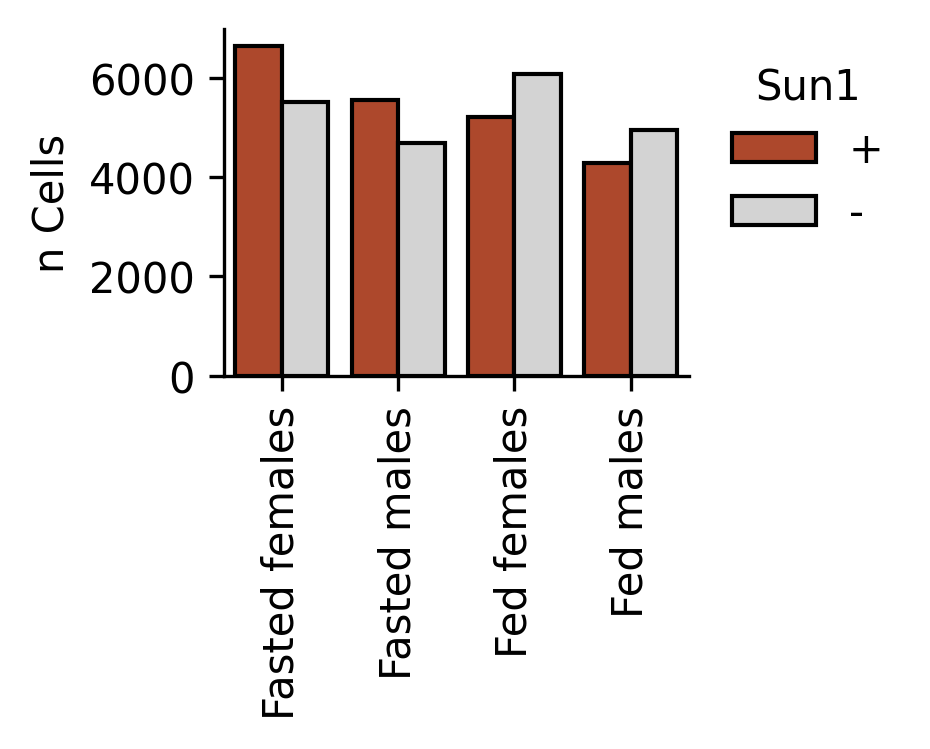

In [8]:
"""Add sun1 column """
gene = 'Sun1'
mask = np.ravel(adata[:, [gene]].layers['counts'].todense() > 0)
adata.obs['Sun1'] = np.where(mask, '+', '-')
adata.obs['sun1'] = np.where(mask, 1, 0)

pdf = adata.obs[['Sun1', 'batch']].value_counts().reset_index(drop=False)
pdf = pdf.sort_values(by=['batch', 'Sun1'])
print(pdf)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 1.5

keyMap = {
    'fasted_f' : 'Fasted females',
    'fed_f' : 'Fed females',
    'fasted_m' : 'Fasted males',
    'fed_m' : 'Fed males',
}

pdf['batch_name'] = pdf['batch'].map(keyMap)

sns.barplot(data=pdf, 
            x='batch_name',
            hue='Sun1',
            ec='k',
            palette=['#c23c17', 'lightgrey'],
            y=0)


sns.despine()
plt.ylabel('n Cells')
plt.xlabel('')

plt.gca().tick_params(axis='x', rotation=90)

sns.move_legend(plt.gca(),
                loc='upper right',
                frameon=False,
                bbox_to_anchor=(1.5, 1))

([<matplotlib.patches.Wedge at 0x152860ceba30>,
 [Text(-0.01975787209259519, 1.0998225431815682, ''),
  Text(0.019757975065412735, -1.099822541331698, '')],
 [Text(-0.010777021141415558, 0.5999032053717644, '51%'),
  Text(0.010777077308406945, -0.5999032043627444, '49%')])

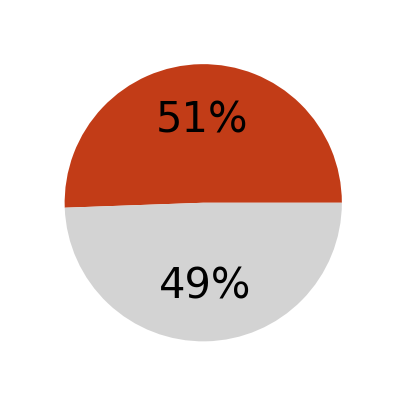

In [9]:
plt.pie(adata.obs['Sun1'].value_counts(), 
        # labels=keys, 
        colors=['#c23c17', 'lightgrey'],
        # lw=1,
        autopct='%.0f%%')

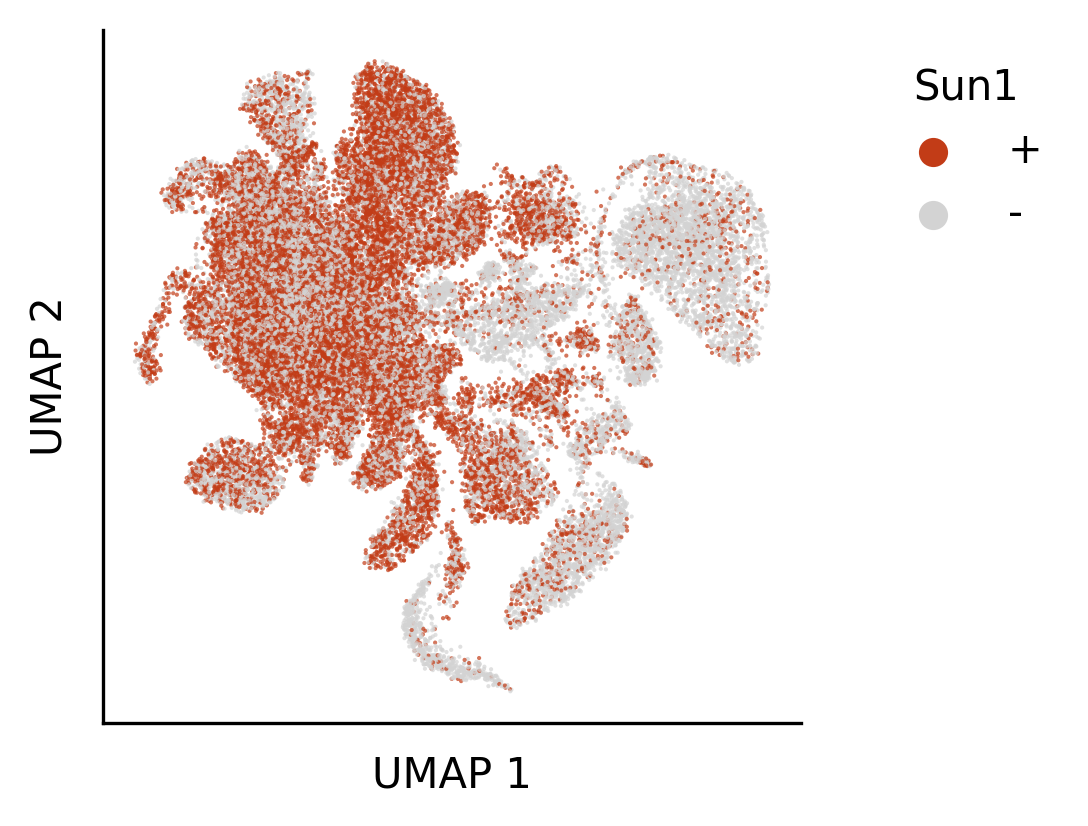

In [10]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3 

sns.scatterplot(data=adata.obs,
                x='UMAP1',
                y='UMAP2',
                # c=adata.obs['color'].to_list(),
                hue='Sun1',
                # hue_order=sorted(adata.obs[key].unique()),
                palette=['#c23c17', 'lightgrey'],
                ec='None',
                alpha=0.7,
                s=1)

plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")

plt.yticks([])
plt.xticks([])

sns.move_legend(plt.gca(),
                title='Sun1',
                frameon=False,
                loc='upper right',
                bbox_to_anchor=(1.4, 1))
sns.despine()

In [11]:
# break

Agrp Sun1 Pos=1.004 Sun1 Neg=1.258 pval=0.000
Npy Sun1 Pos=1.115 Sun1 Neg=1.417 pval=0.000
Nr5a1 Sun1 Pos=0.682 Sun1 Neg=0.870 pval=0.000
Pomc Sun1 Pos=1.035 Sun1 Neg=1.452 pval=0.000
Mc4r Sun1 Pos=0.632 Sun1 Neg=0.819 pval=0.000
Gnrhr Sun1 Pos=0.606 Sun1 Neg=0.787 pval=0.000
Gnrh1 Sun1 Pos=0.638 Sun1 Neg=0.901 pval=0.000
Ghrh Sun1 Pos=0.867 Sun1 Neg=1.174 pval=0.000
Ghrhr Sun1 Pos=0.874 Sun1 Neg=1.075 pval=0.464
Sst Sun1 Pos=0.926 Sun1 Neg=1.246 pval=0.000
Esr1 Sun1 Pos=0.917 Sun1 Neg=1.090 pval=0.000
Lepr Sun1 Pos=1.004 Sun1 Neg=1.233 pval=0.000
Pnoc Sun1 Pos=0.707 Sun1 Neg=0.970 pval=0.000
Adcyap1 Sun1 Pos=0.776 Sun1 Neg=1.015 pval=0.000
Foxp2 Sun1 Pos=1.511 Sun1 Neg=1.631 pval=0.000
Dlk1 Sun1 Pos=1.043 Sun1 Neg=1.235 pval=0.000
Kiss1 Sun1 Pos=0.625 Sun1 Neg=0.993 pval=0.579
Pdyn Sun1 Pos=0.751 Sun1 Neg=1.013 pval=0.000
Rprm Sun1 Pos=0.750 Sun1 Neg=1.041 pval=0.000
Oxtr Sun1 Pos=0.627 Sun1 Neg=0.794 pval=0.000
Gria3 Sun1 Pos=1.674 Sun1 Neg=1.719 pval=0.000
Grik3 Sun1 Pos=1.020 Sun1 

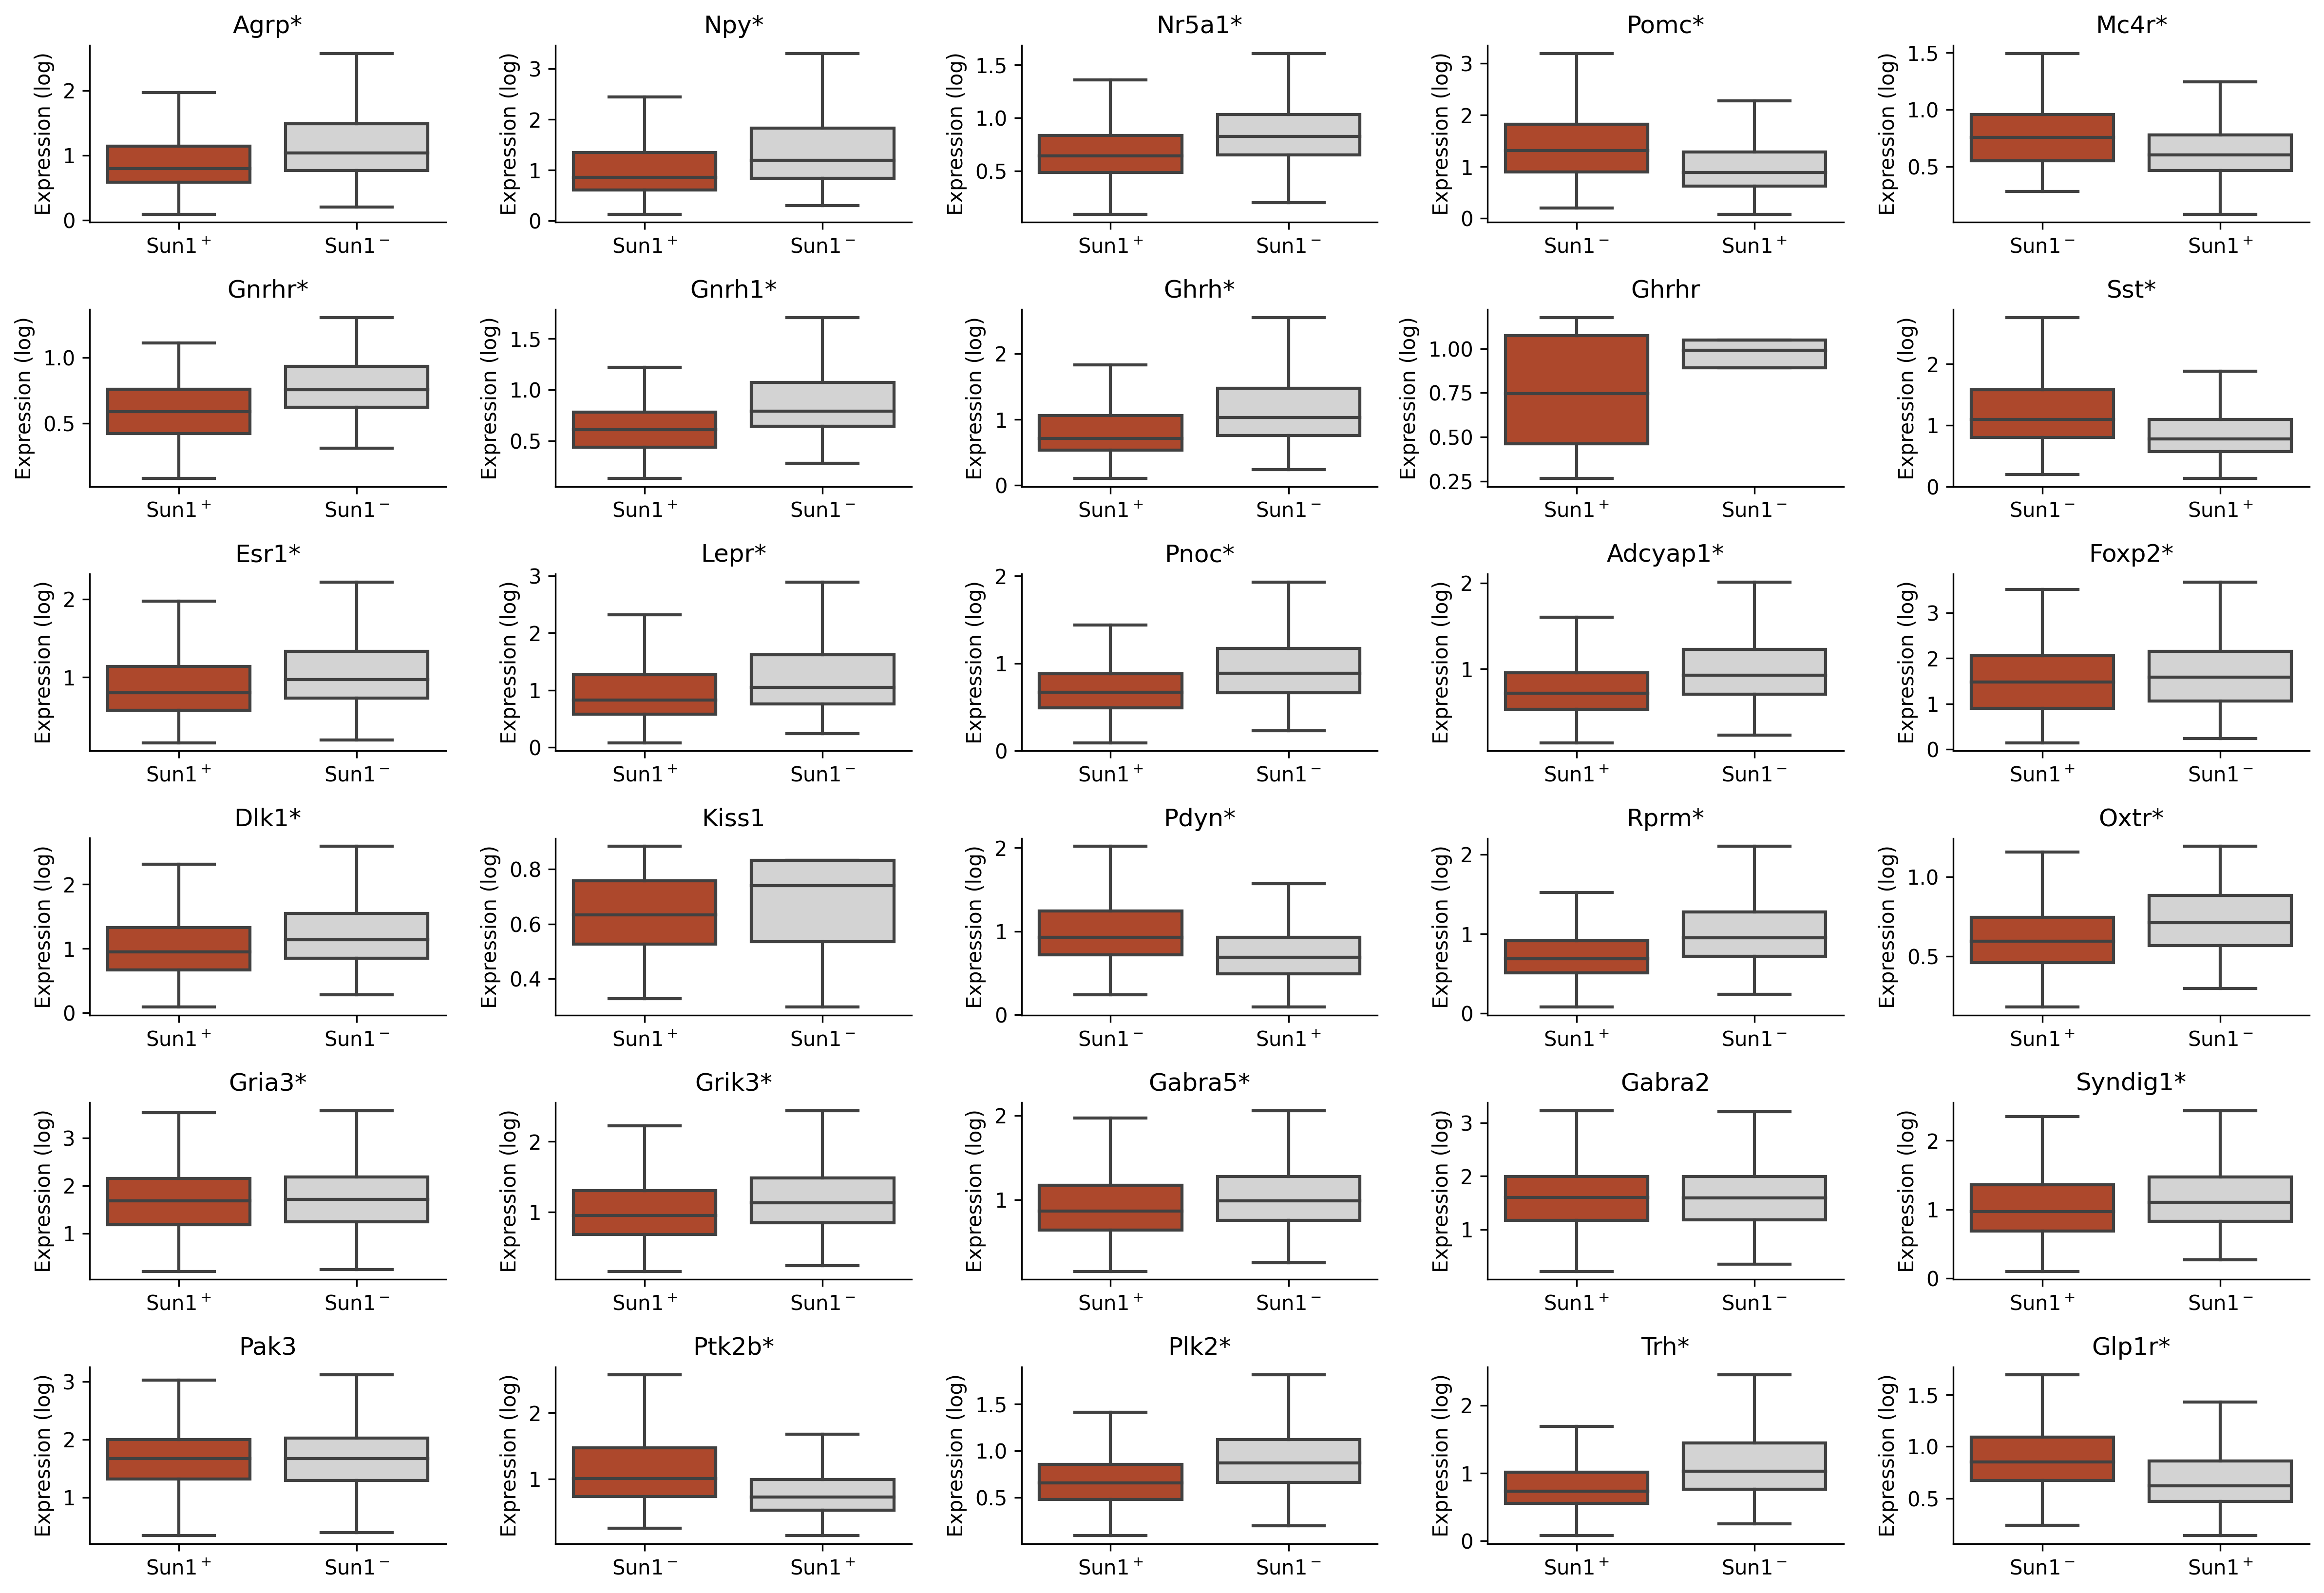

In [12]:
alpha = 0.01
genes = [
    "Agrp", 
    "Npy", 
    "Nr5a1", 
    "Pomc", 
    "Mc4r", 
    "Gnrhr", 
    "Gnrh1", 
    "Ghrh", 
    "Ghrhr", 
    "Sst", 
    "Esr1",
    "Lepr",
    "Pnoc",
    "Adcyap1",
    "Foxp2", 
    "Dlk1",
    "Kiss1", 
    # "Tac2", 
    "Pdyn", 
    "Rprm",
    "Oxtr",
    # "Drd2",
    "Gria3", 
    # "Grik1", 
    "Grik3", 
    "Gabra5", 
    "Gabra2", 
    "Syndig1",
    "Pak3",
    "Ptk2b", 
    "Plk2",
    "Trh",
    "Glp1r",
]


len(genes)

ef = pd.DataFrame(adata[:, genes].X.todense(), columns=genes)
ef['flag'] = adata.obs['sun1'].to_list()
ef['label'] = ef['flag'].map({1: r"Sun1$^+$", 0 : r"Sun1$^-$"})


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 16, 11
fig, axs = plt.subplots(6, 5)
axs = axs.ravel()

for i, g in enumerate(genes):

    pedf = ef[ef[g] > 0]
    
    sns.boxplot(pedf,
                y=g,
                x='label',
                showfliers=False,
                ax=axs[i],
                palette=['#c23c17', 'lightgrey', ],)

    axs[i].set_ylabel(f"Expression (log)")
    axs[i].set_xlabel(f"")

    s1p = pedf[(pedf['flag'] == 1)][g].to_numpy()
    s1n = pedf[(pedf['flag'] == 0)][g].to_numpy()

    score, pval = scipy.stats.ranksums(s1p, s1n)
    print(f"{g} Sun1 Pos={s1p.mean():.3f} Sun1 Neg={s1n.mean():.3f} {pval=:.3f}")

    sig = ""
    if pval <= alpha:
        sig = "*"
        
    axs[i].set_title(f"{g}{sig}")

    
sns.despine()
plt.tight_layout()

In [13]:
# break

C7_named_clean  pos_count  count  neg_count   percent
0   Astro-Ependymal        433   2095       1662  0.206683
1              GABA       7478  13852       6374  0.539850
2               GLU      12780  21249       8469  0.601440
3            Immune        116    771        655  0.150454
4   Oligo+Precursor        679   4163       3484  0.163104

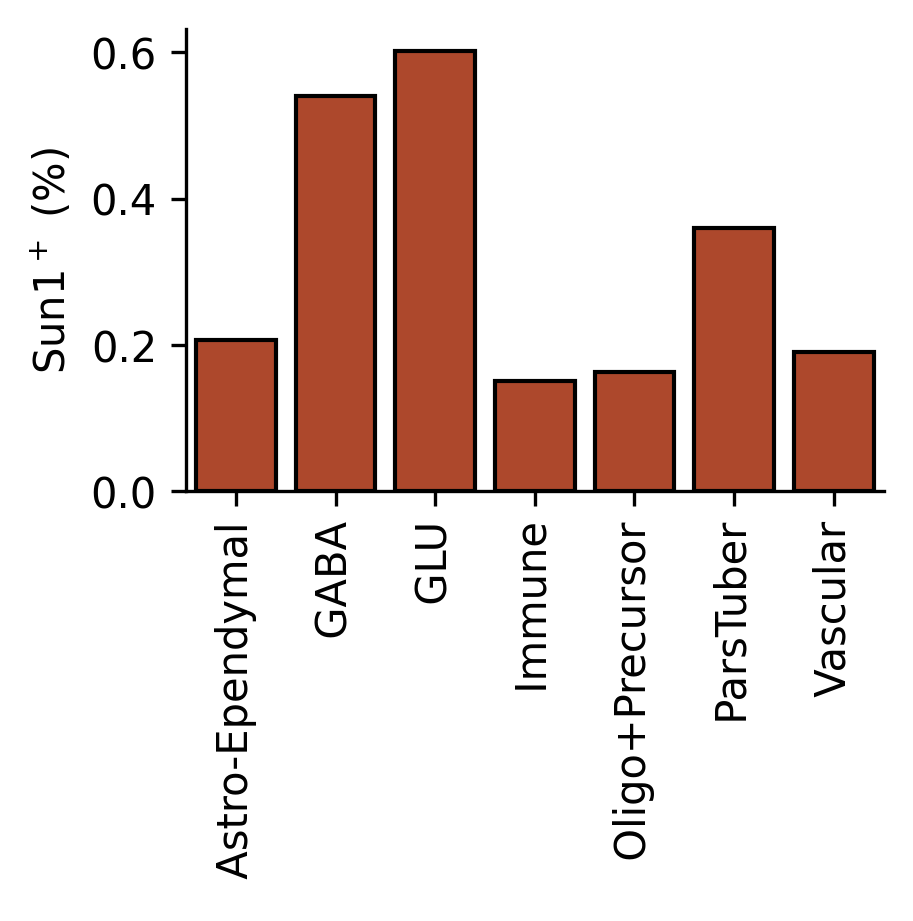

In [14]:
pdf = adata.obs.copy()

pdf = pdf.groupby(['C7_named_clean']).agg(
    pos_count = ('sun1', 'sum'),
    count = ('sun1', 'count'),
).reset_index(drop=False)


pdf['neg_count'] = pdf['count'] - pdf['pos_count']
pdf['percent'] = pdf['pos_count'] / pdf['count']

# pdf = pd.melt(pdf, id_vars='C7_named_clean')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2 

sns.barplot(data=pdf, 
            x='C7_named_clean',
            y='percent',
            color='#c23c17',
            # palette='nipy_spectral',
            ec='k',)

plt.xlabel("")
plt.ylabel(r"Sun1$^+$ (%)")
plt.gca().tick_params(axis='x', rotation=90)
# plt.xlabel("n Cells (Sun1+)")
# plt.xlabel("n Cells (Sun1-)")

sns.despine()

pdf.head()

C25_named_clean  pos_count  count  neg_count   percent
0       Astrocytes        395   1711       1316  0.230859
1   Ependymal-like        108    449        341  0.240535
2      Fibroblasts         24    193        169  0.124352
3           GABA-2       1494   2859       1365  0.522560
4           GABA-3       1136   2141       1005  0.530593

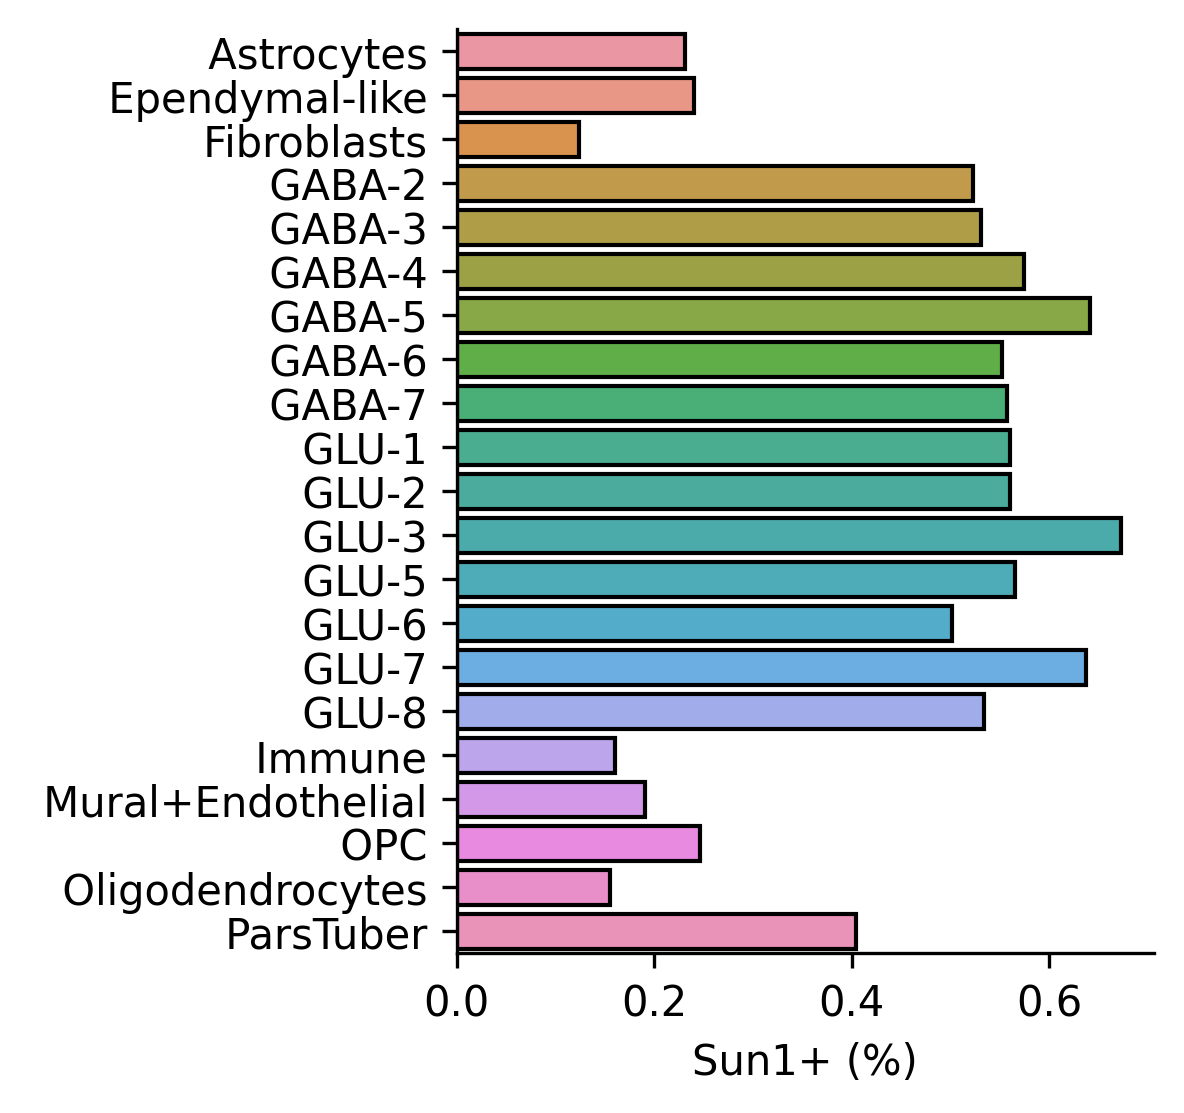

In [15]:
pdf = adata.obs.copy()

pdf = pdf.groupby(['C25_named_clean']).agg(
    pos_count = ('sun1', 'sum'),
    count = ('sun1', 'count'),
).reset_index(drop=False)


pdf['neg_count'] = pdf['count'] - pdf['pos_count']
pdf['percent'] = pdf['pos_count'] / pdf['count']

# pdf = pd.melt(pdf, id_vars='C7_named_clean')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 4

sns.barplot(data=pdf, 
            y='C25_named_clean',
            x='percent',
            # palette='nipy_spectral',
            ec='k',)

plt.ylabel("")
plt.xlabel("Sun1+ (%)")
# plt.xlabel("n Cells (Sun1+)")
# plt.xlabel("n Cells (Sun1-)")

sns.despine()

pdf.head()

In [26]:
" Differential expression on Sun1"

adata.obs['SUN1'] = np.where(adata.obs['sun1'] == 1, 'Positive', 'Negative')
adata.obs['SUN1'] = adata.obs['SUN1'].astype('category')

# get marker genes
sc.tl.rank_genes_groups(adata, 
                        groupby='SUN1',
                        method='wilcoxon',
                        key_added='SUN1_TEST',
                        corr_method='benjamini-hochberg')

deg = sc.get.rank_genes_groups_df(adata, 
                                  group='Positive',
                                  key='SUN1_TEST')


deg.head()

names      scores  logfoldchanges  pvals  pvals_adj
0     Sun1  179.437424       30.555336    0.0        0.0
1     Nrg3   56.762554        1.119239    0.0        0.0
2  Gm26871   54.250221        1.079866    0.0        0.0
3  Fam155a   53.953411        1.042775    0.0        0.0
4   Rbfox1   52.472698        1.174585    0.0        0.0

... storing 'Cell Type' as categorical


categories: GABA, GLU, Oligodendrocytes, etc.
var_group_labels: Negative, Positive


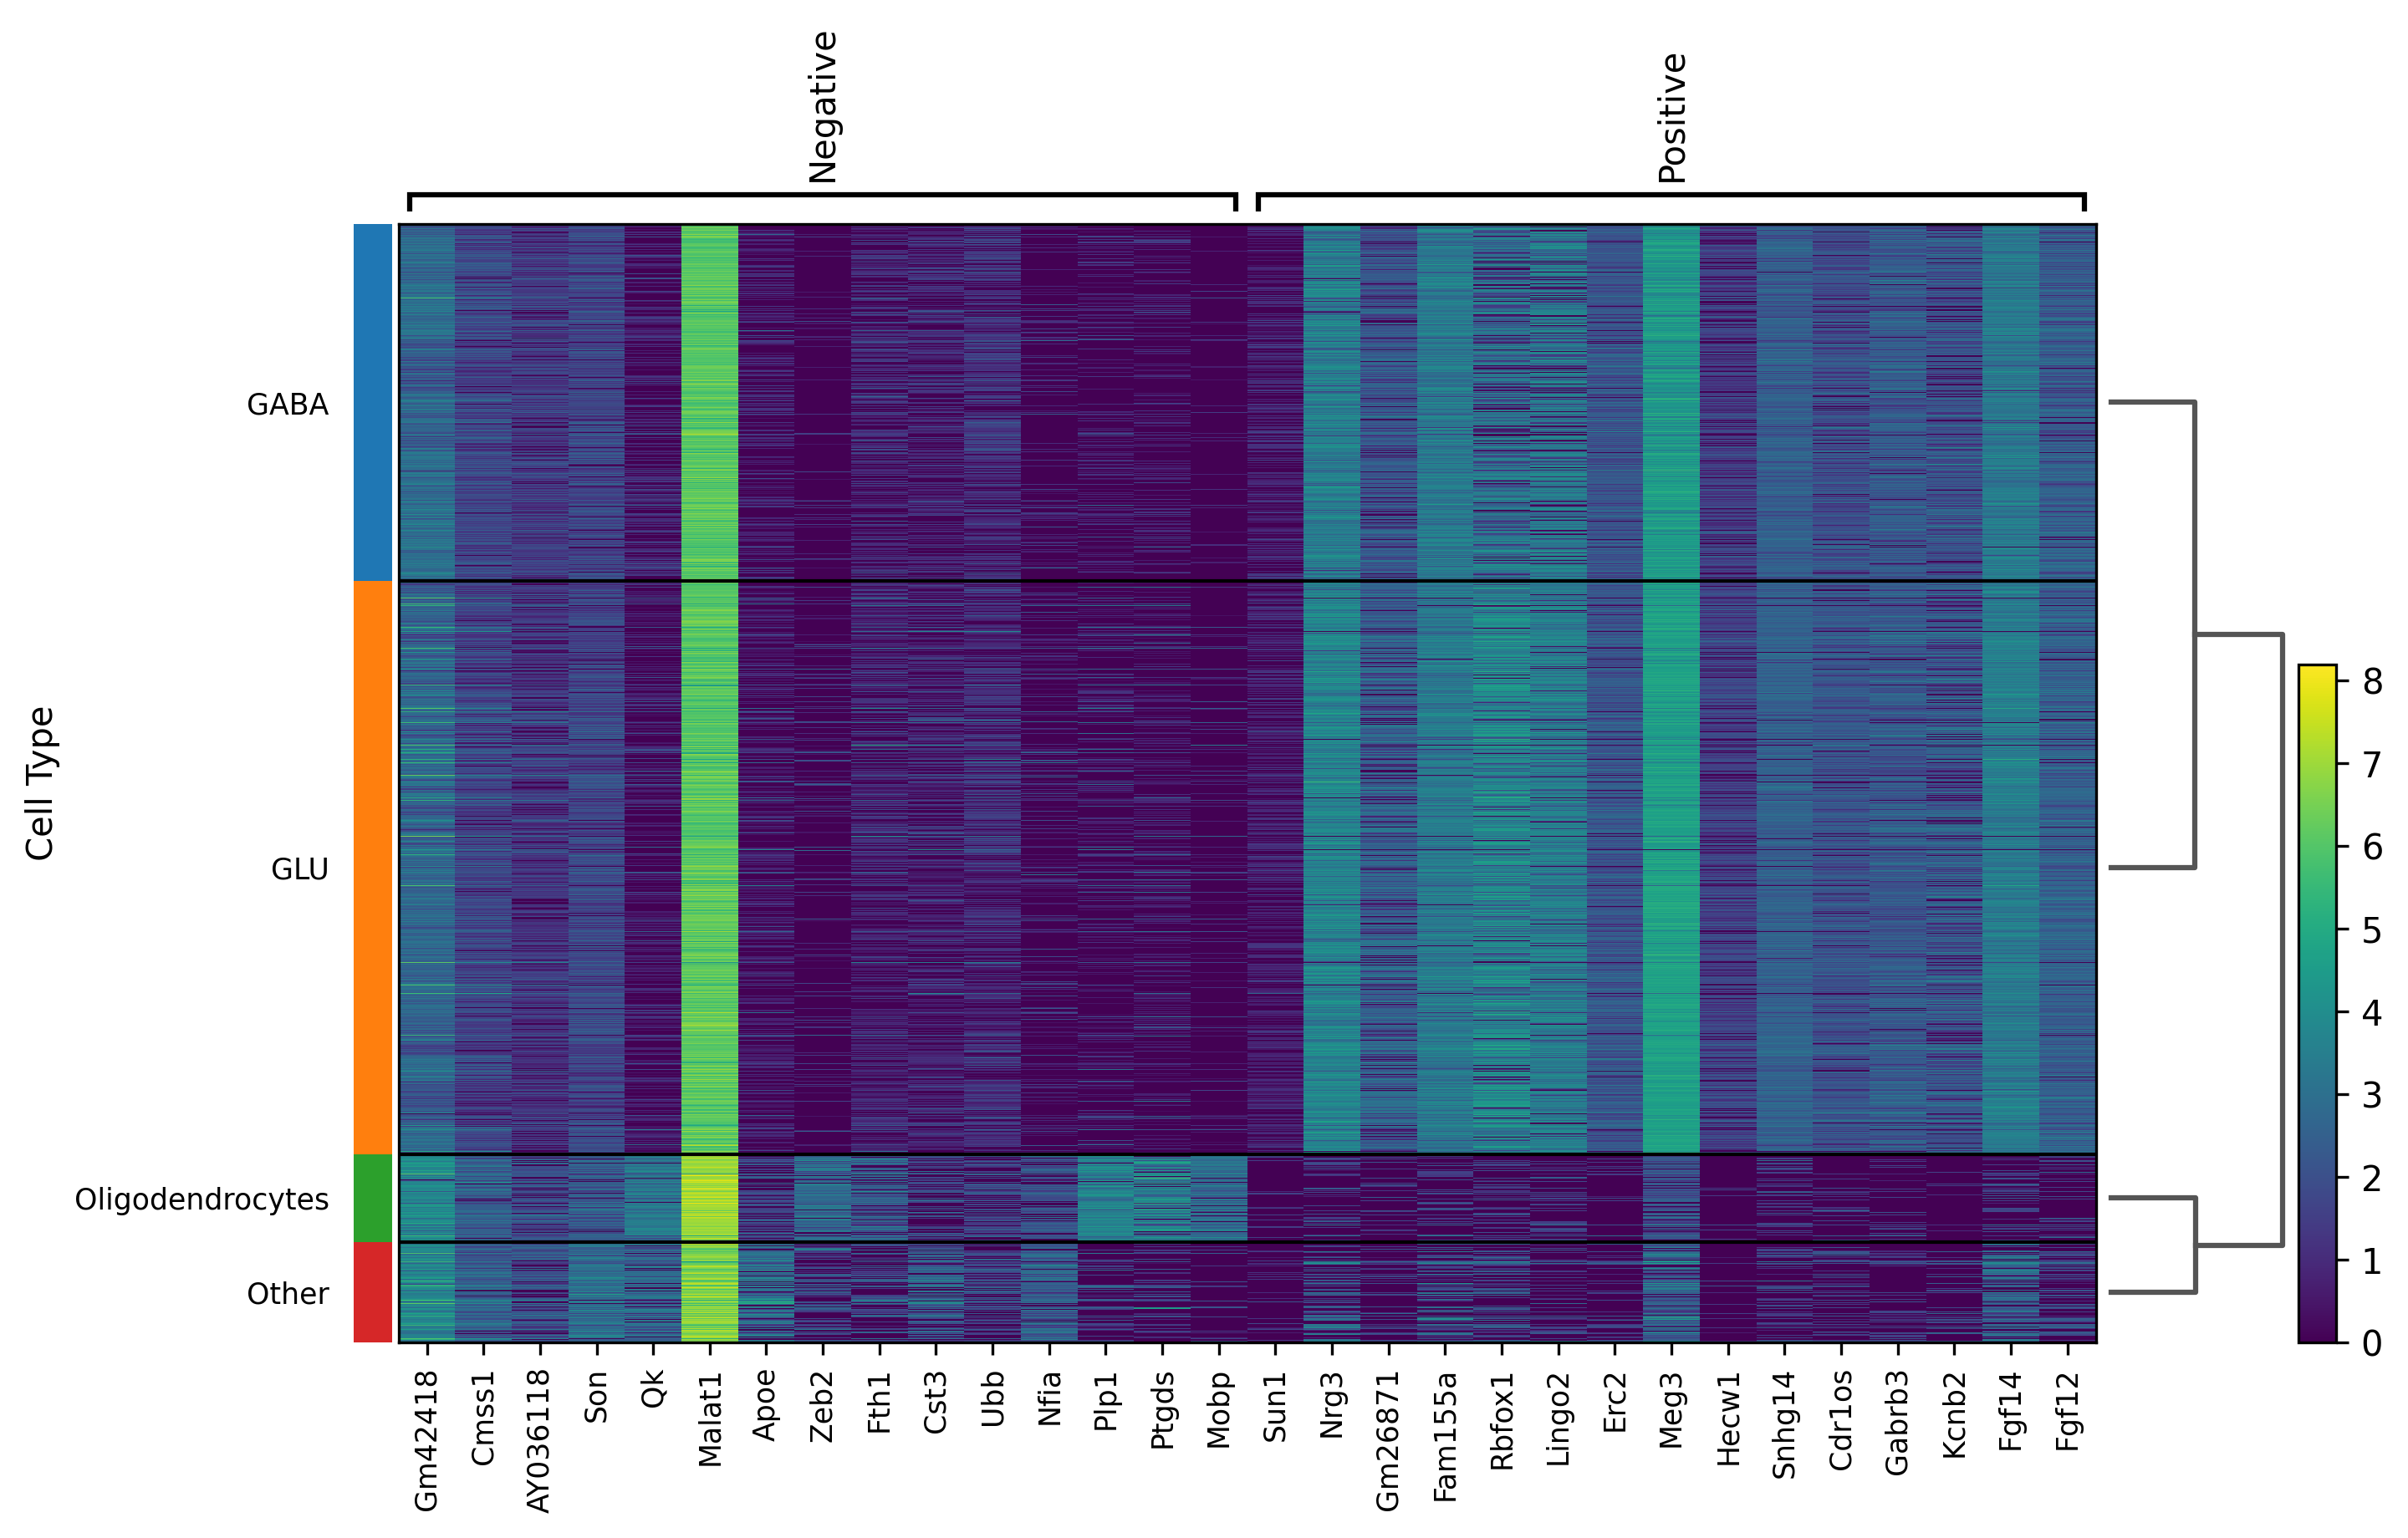

In [51]:
pdf = adata.copy()
pdf.obs = pdf.obs.rename(columns={'Sun1' : 'Sun1_flag'})


tmap = {
 ' GABA' : "GABA",
 ' Immune' : "Other",
 ' Oligodendrocytes' : "Oligodendrocytes",
 ' GLU' : "GLU",
 ' OPC' : "Other",
 ' Astrocytes' : "Other",
 ' Ependymal' : "Other",
 ' Mural+Endothelial' : "Other",
 ' Fibroblasts' : "Other",
 ' ParsTuber': "Other",
}

pdf.obs['Cell Type'] = pdf.obs['broad_type'].map(tmap)

sc.pl.rank_genes_groups_heatmap(pdf, 
                                n_genes=15, 
                                key="SUN1_TEST", 
                                groupby="Cell Type",
                                show_gene_labels=True)


categories: fasted_f, fasted_m, fed_f, etc.
var_group_labels: Negative, Positive


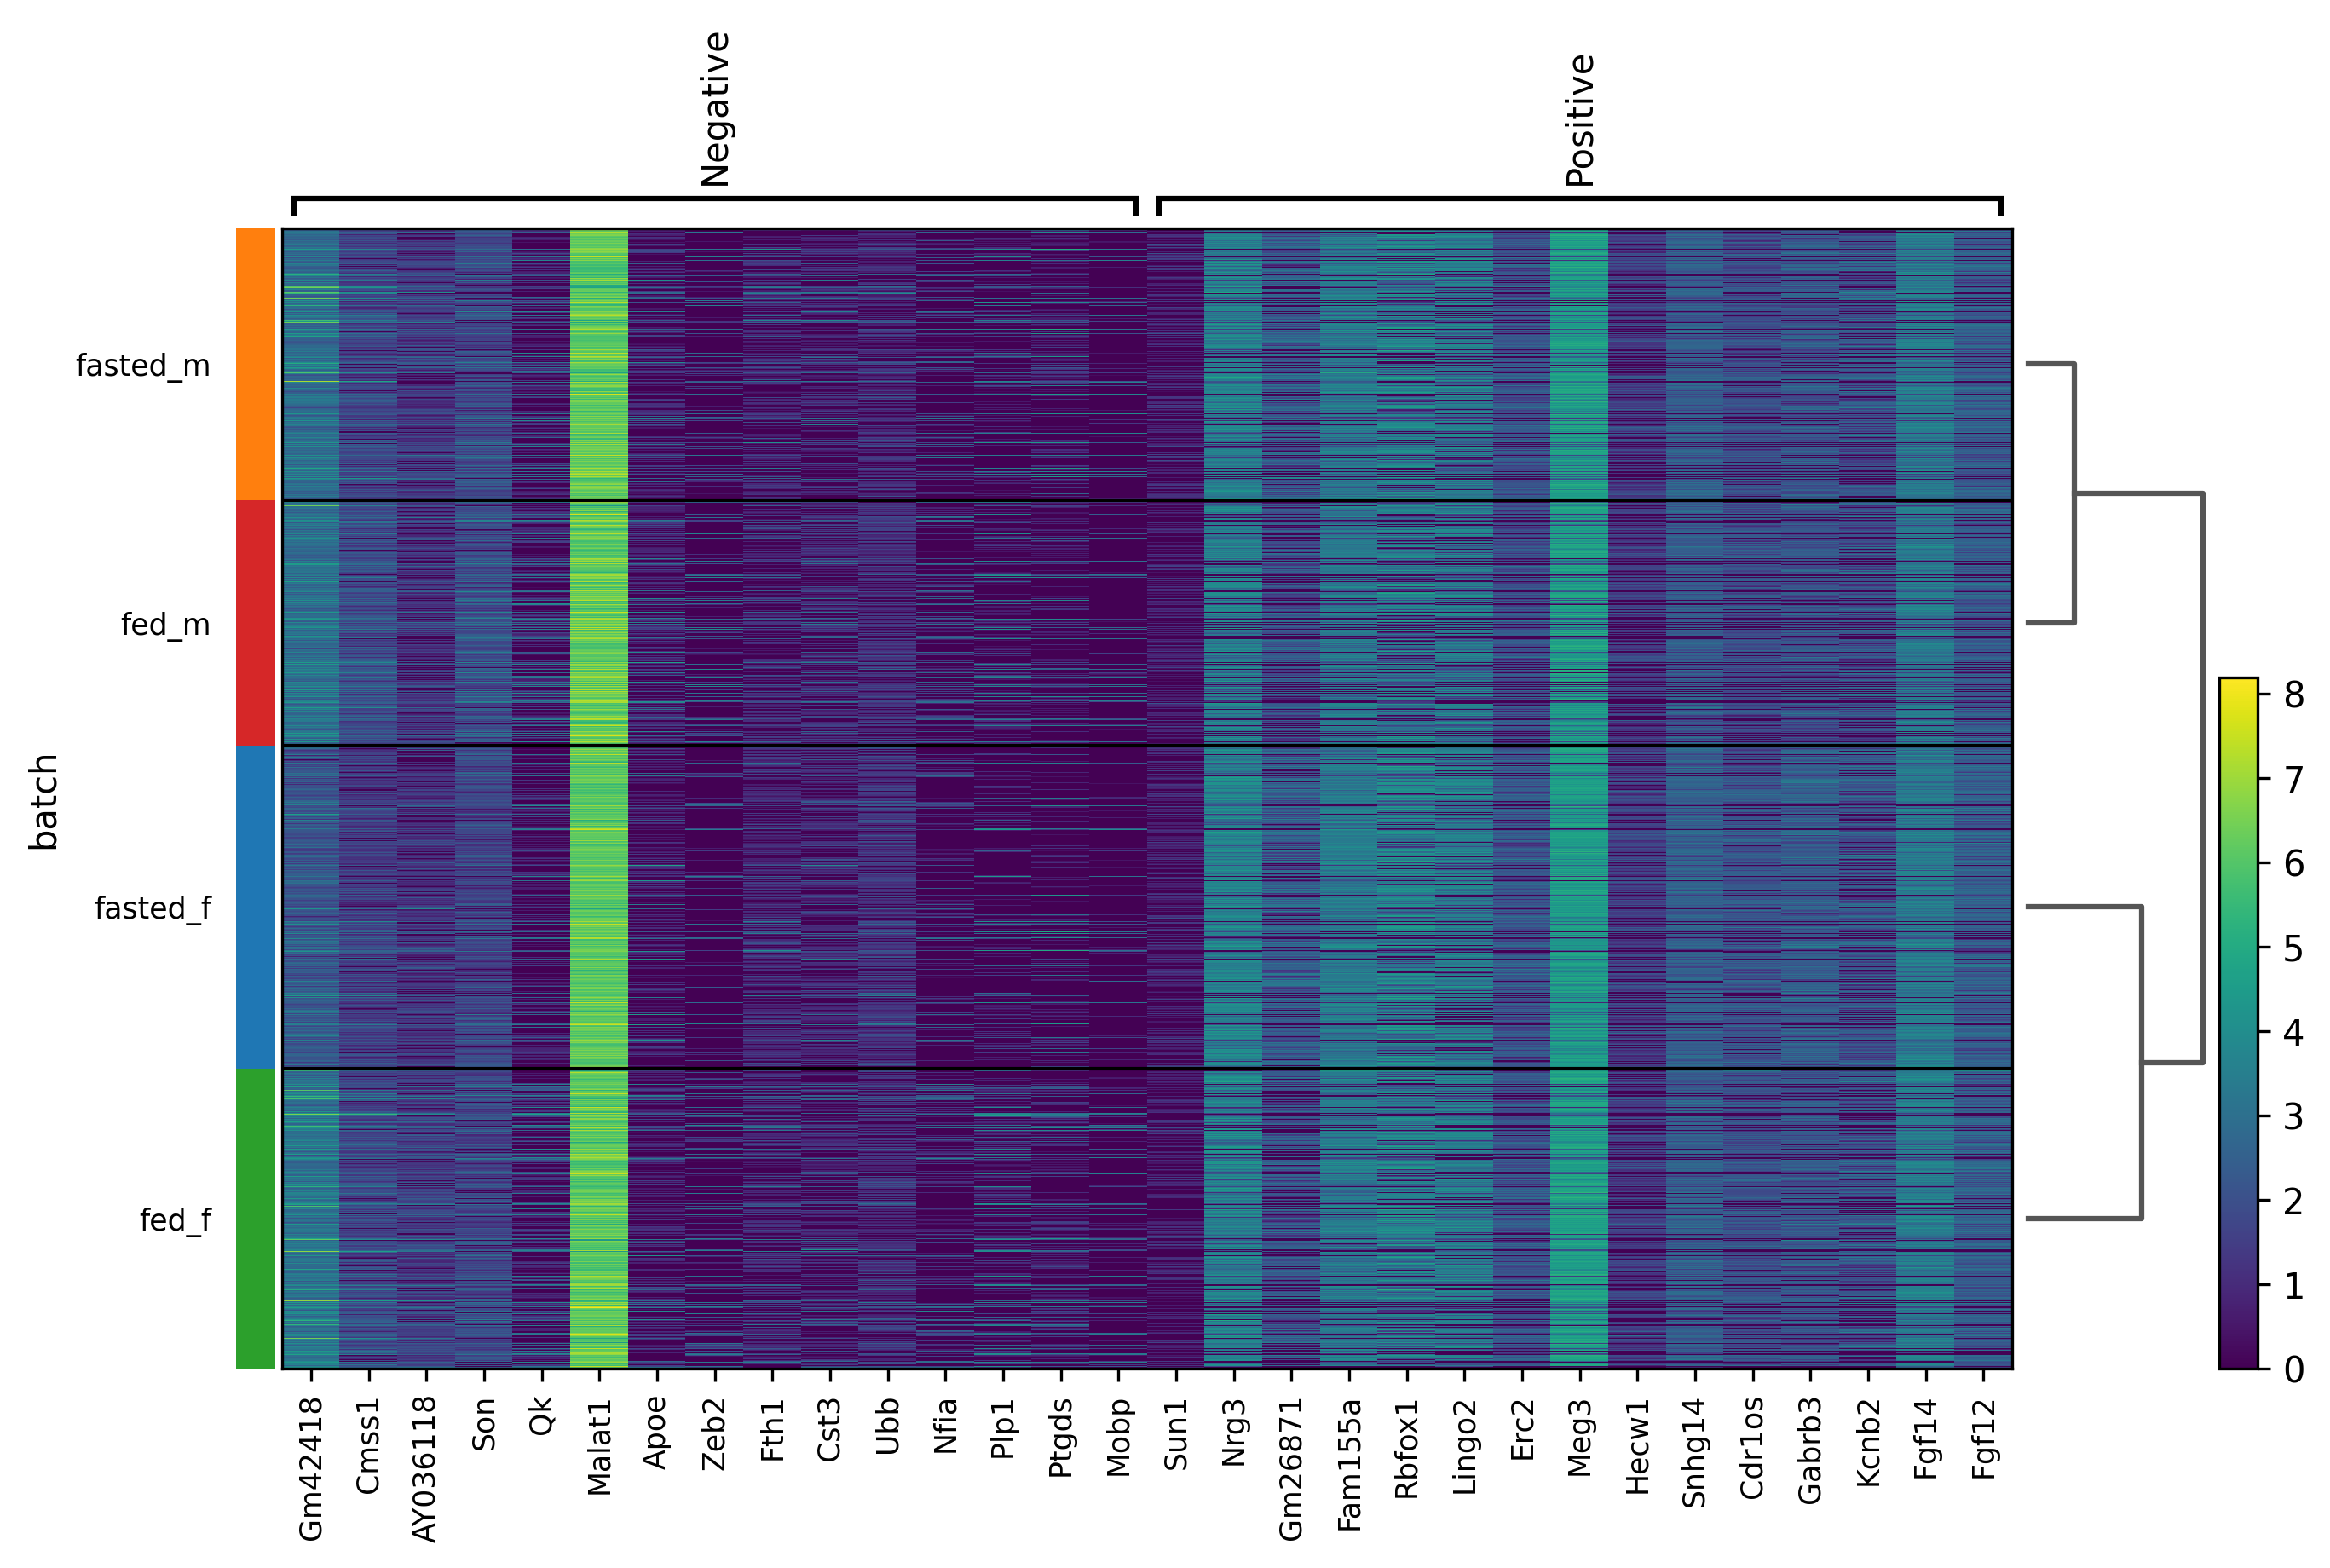

In [61]:
sc.pl.rank_genes_groups_heatmap(pdf, 
                                n_genes=15, 
                                key="SUN1_TEST", 
                                groupby="batch",
                                show_gene_labels=True)

... storing 'Mc3r_flag' as categorical


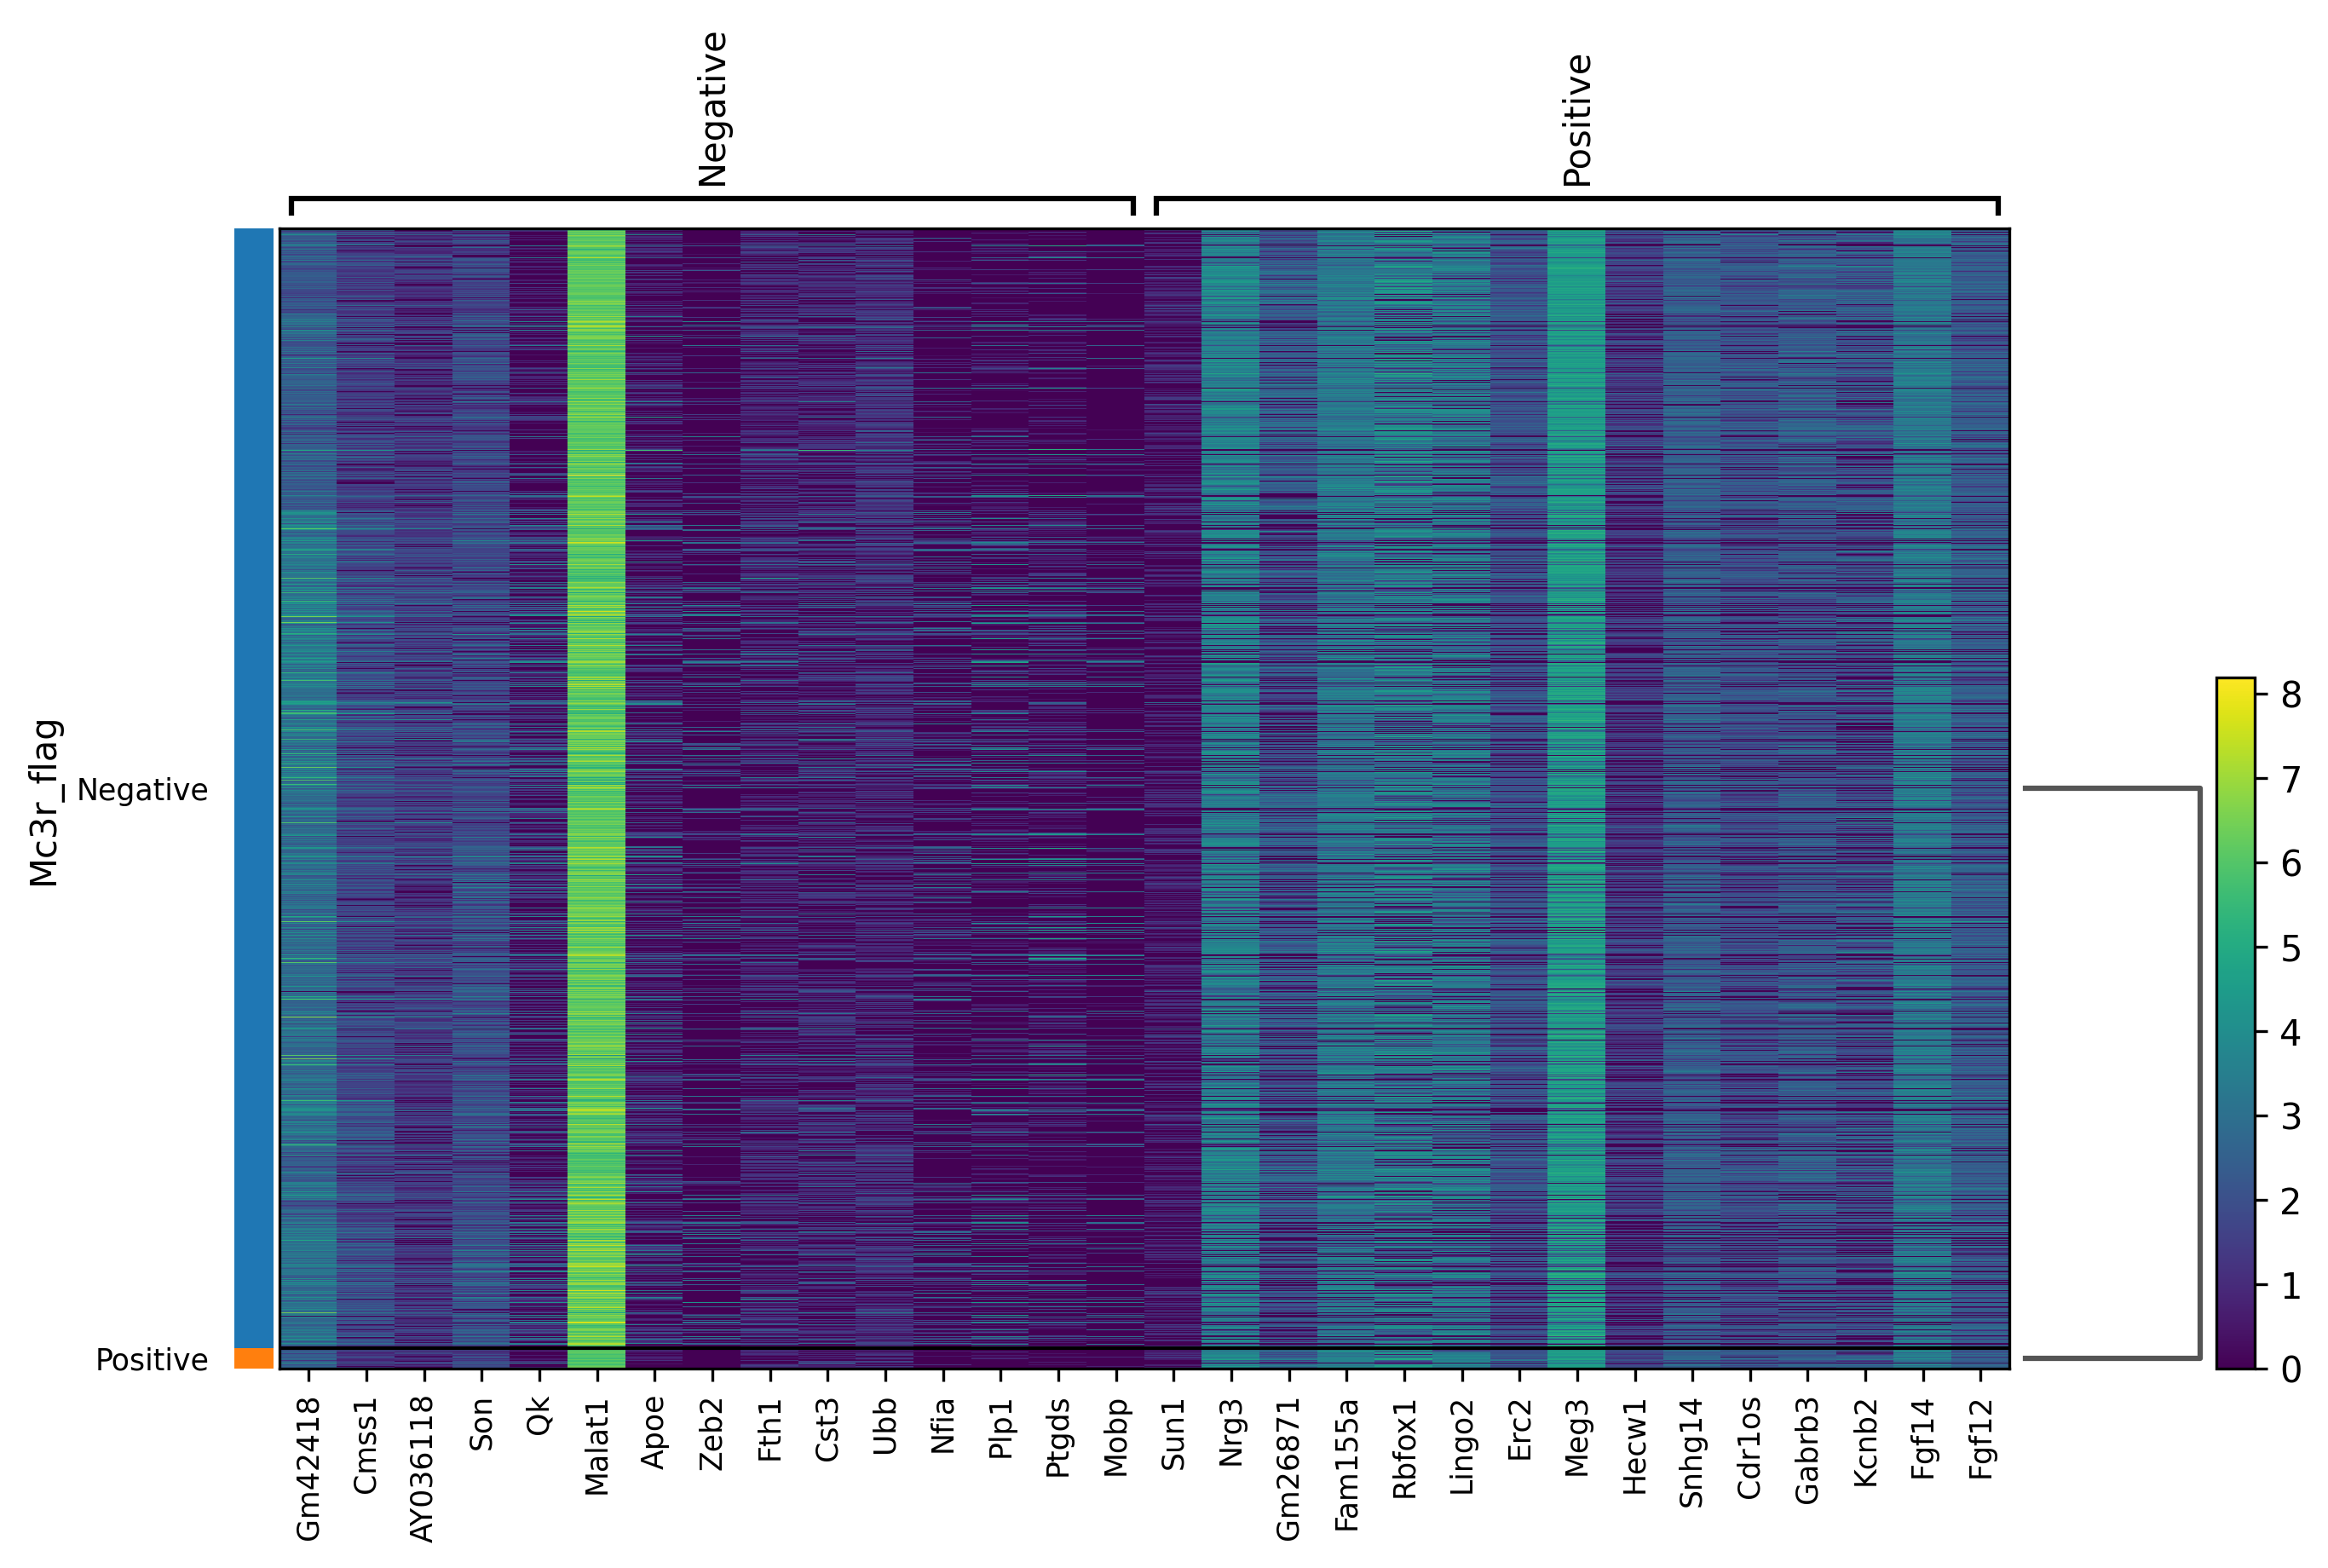

In [64]:

mask = np.ravel(pdf[:, ['Mc3r']].layers['counts'].todense() > 0)
pdf.obs['Mc3r_flag'] = np.where(mask, 'Positive', 'Negative')

sc.pl.rank_genes_groups_heatmap(pdf, 
                                n_genes=15, 
                                key="SUN1_TEST", 
                                groupby="Mc3r_flag",
                                show_gene_labels=True)

Tue Oct 24 15:25:48 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


deg.shape=(25060, 5) sig.shape=(12748, 5)


/tmp/ipykernel_562614/2121648740.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['logp'] = -1 * np.log10(cdf['adj_p_val'])
/tmp/ipykernel_562614/2121648740.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['pname'] = cdf['path_name'].apply(lambda x: x.split("(")[0].strip().title())


rank  \
0     1   
1     2   
2     3   
3     4   
4     5   

                                                                          path_name  \
0          SRP-dependent cotranslational protein targeting to membrane (GO:0006614)   
1                                              cytoplasmic translation (GO:0002181)   
2                        cotranslational protein targeting to membrane (GO:0006613)   
3                                              protein targeting to ER (GO:0045047)   
4  nuclear-transcribed mRNA catabolic process, nonsense-mediated decay (GO:0000184)   

          p_val    z_score  combined_score  \
0  3.484486e-13  14.941759      428.608616   
1  5.936778e-13  14.357417      404.196322   
2  7.058935e-13  14.172625      396.540310   
3  3.059936e-12  12.700664      336.727962   
4  1.320437e-11  11.385509      285.212384   

                                                                                                 overlapping_genes  \
0  [RPL41, RPL3, RPS8, RPLP1, RPL35A, RPL9, RPS27, RPS29, RPL13, RPL38, RPL37, RPS27A, RPS21, RPS24, RPL19, RPS23]   
1  [RPL41, RPL3, RPS8, RPLP1, RPL35A, RPL9, RPS27, RPS29, RPL13, RPL38, RPL37, RPS27A, RPS21, RPS24, RPL19, RPS23]   
2  [RPL41, RPL3, RPS8, RPLP1, RPL35A, RPL9, RPS27, RPS29, RPL13, RPL38, RPL37, RPS27A, RPS21, RPS24, RPL19, RPS23]   
3  [RPL41, RPL3, RPS8, RPLP1, RPL35A, RPL9, RPS27, RPS29, RPL13, RPL38, RPL37, RPS27A, RPS21, RPS24, RPS23, RPL19]   
4  [RPL41, RPL3, RPS8, RPLP1, RPL35A, RPL9, RPS27, RPS29, RPL13, RPL38, RPL37, RPS27A, RPS21, RPS24, RPS23, RPL19]   

      adj_p_val                    database      logp  \
0  4.821253e-10  GO_Biological_Process_2021  9.316840   
1  4.821253e-10  GO_Biological_Process_2021  9.316840   
2  4.821253e-10  GO_Biological_Process_2021  9.316840   
3  1.567452e-09  GO_Biological_Process_2021  8.804806   
4  5.411152e-09  GO_Biological_Process_2021  8.266710   

                                                                 pname  
0          Srp-Dependent Cotranslational Protein Targeting To Membrane  
1                                              Cytoplasmic Translation  
2                        Cotranslational Protein Targeting To Membrane  
3                                              Protein Targeting To Er  
4  Nuclear-Transcribed Mrna Catabolic Process, Nonsense-Mediated Decay

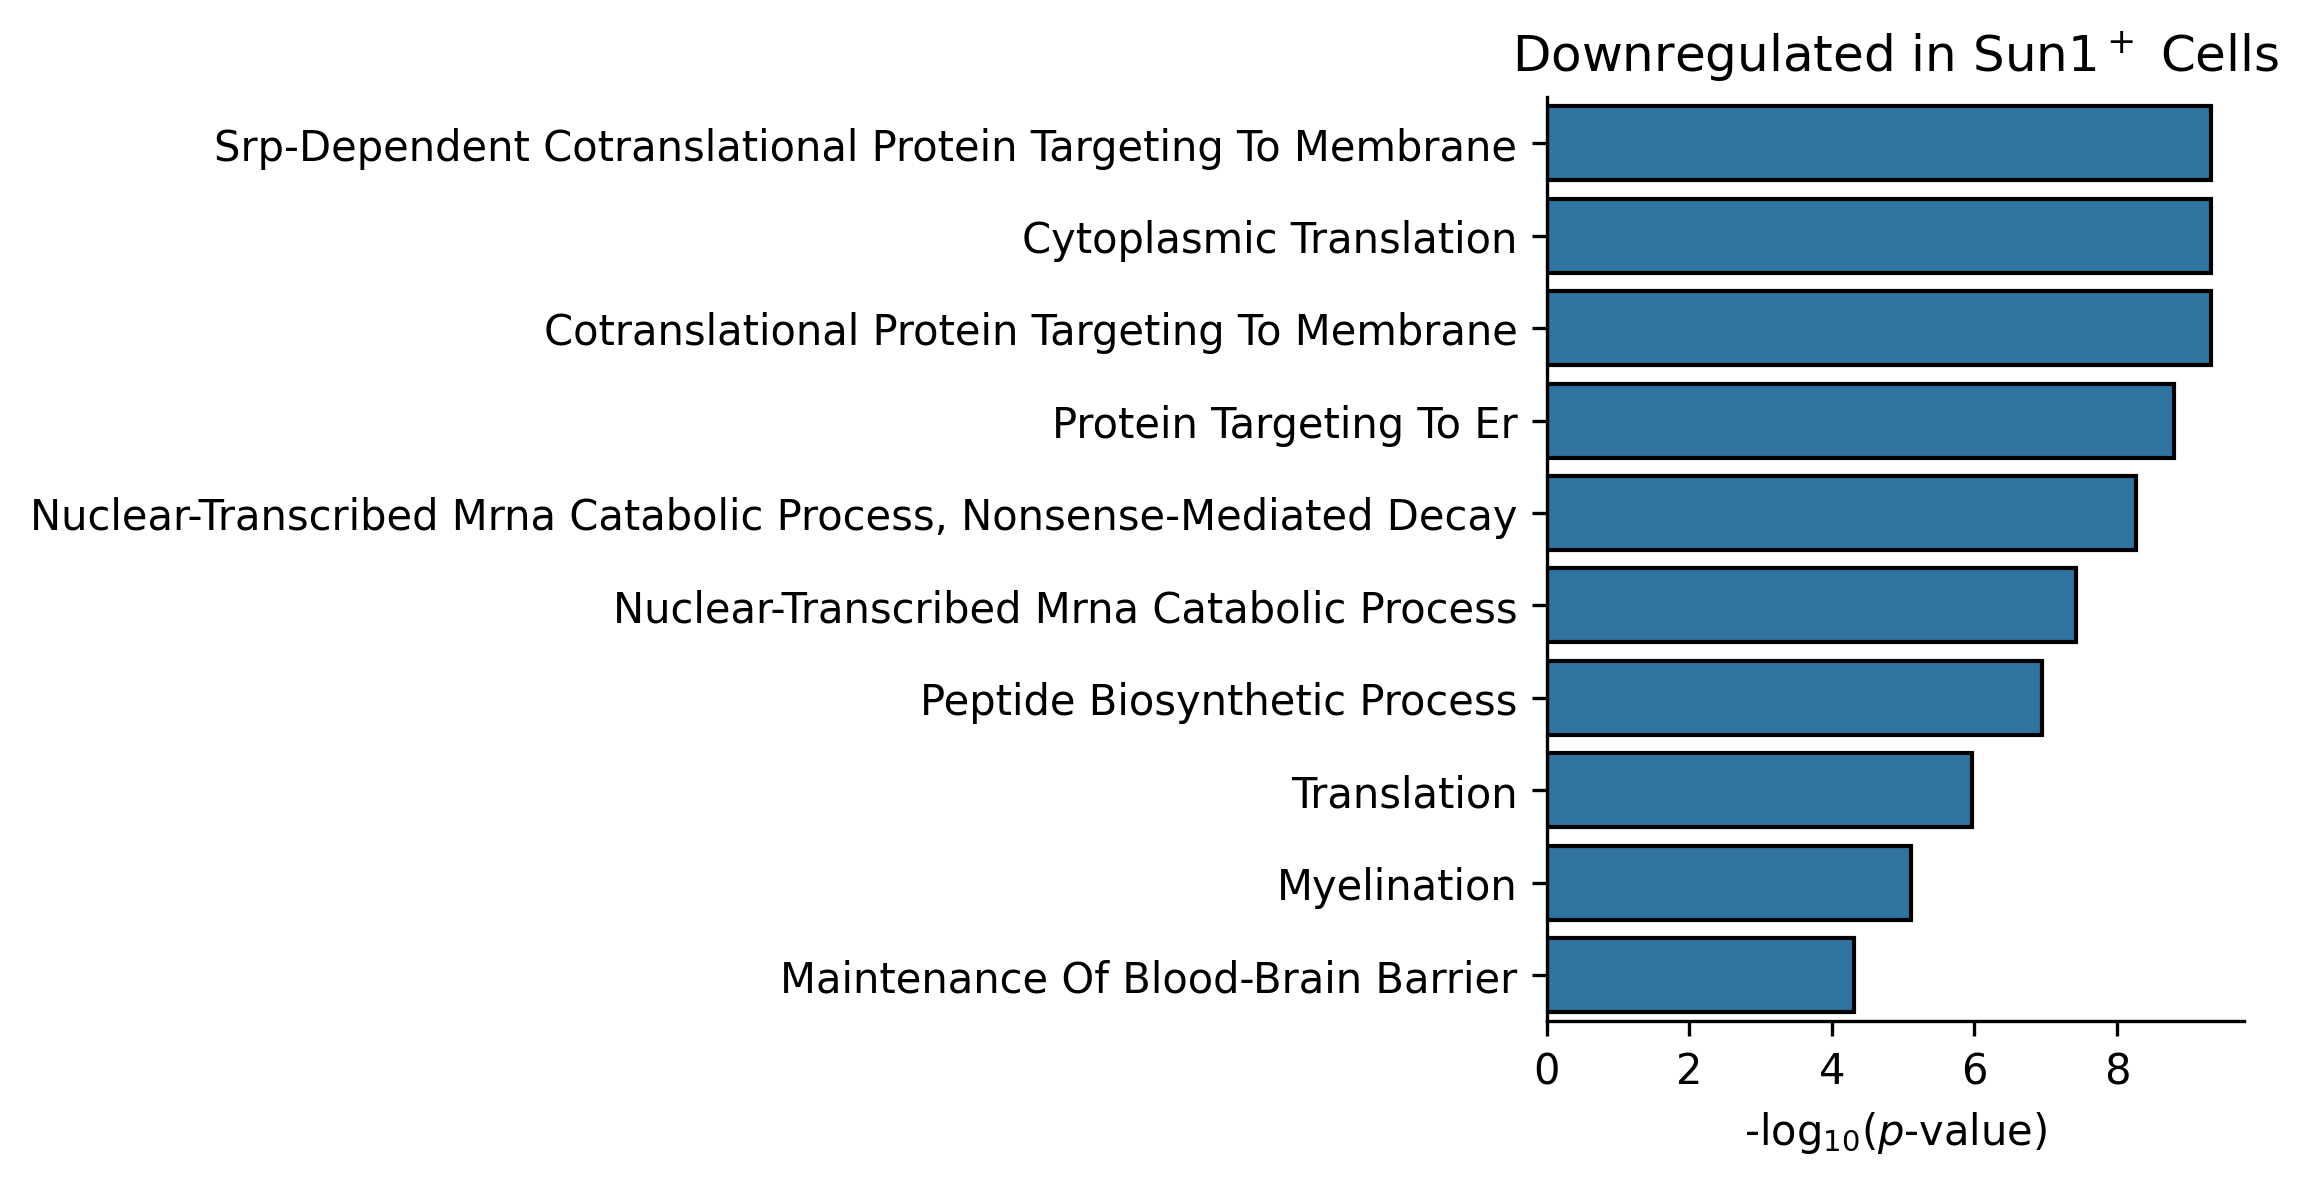

In [60]:
alpha = 0.01
sig = deg[deg['pvals_adj'] <= alpha].reset_index(drop=True)
print(f"{deg.shape=} {sig.shape=}")


# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

e_alpha = 0.05
n_query = 300

query_genes = sig['names'].tail(n_query).to_list()

edf = gget.enrichr(query_genes, database=db)
pd.set_option('display.max_colwidth', 150)
# print(edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(30))


n_plot = 20
cdf = edf.head(10)
cdf['logp'] = -1 * np.log10(cdf['adj_p_val'])
cdf['pname'] = cdf['path_name'].apply(lambda x: x.split("(")[0].strip().title())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 4

sns.barplot(data=cdf, 
            x='logp',
            y='pname',
            ec='k',
            color='C0')

plt.ylabel("")
plt.xlabel(r"-log$_{10}$($p$-value)")
plt.title(r"Downregulated in Sun1$^+$ Cells")
sns.despine()
cdf.head()

deg.shape=(25060, 5) sig.shape=(12748, 5)


/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'Fold Change (log$_{2}$)')

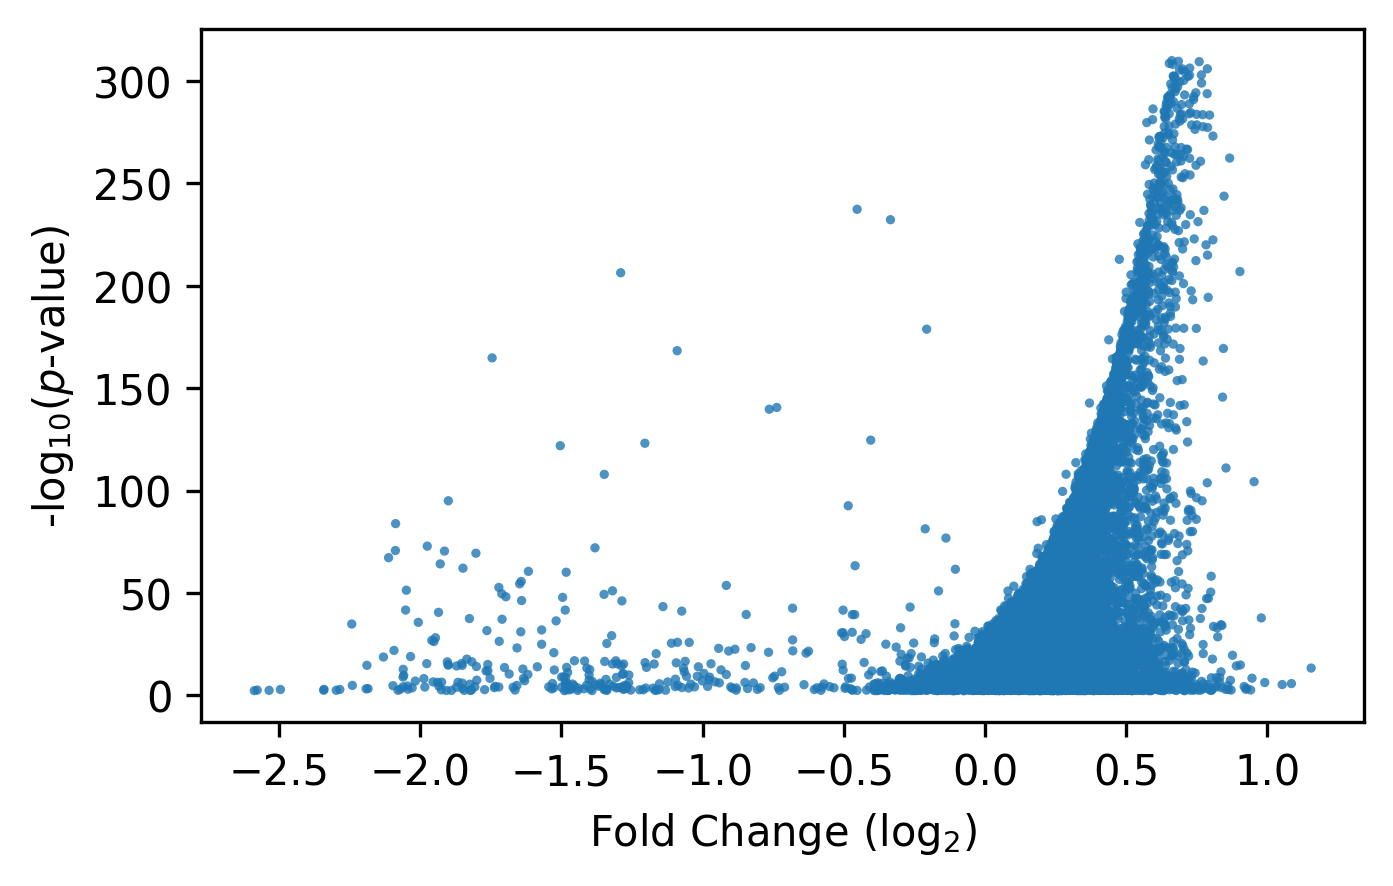

In [53]:
alpha = 0.01
sig = deg[deg['pvals_adj'] <= alpha].reset_index(drop=True)
print(f"{deg.shape=} {sig.shape=}")
sig['log10p'] = -1 * np.log10(sig['pvals'])

sig = sig.sort_values(by='logfoldchanges', ascending=False)
sig.head()


""" VOLCANO PLOTS """

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 3

sns.scatterplot(data=sig, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.8,
                zorder=1,
                s=5)

plt.ylabel(r"-log$_{10}$($p$-value)")
plt.xlabel(r"Fold Change (log$_{2}$)")



f_GABA
categories: fasted, fed
var_group_labels: Negative, Positive


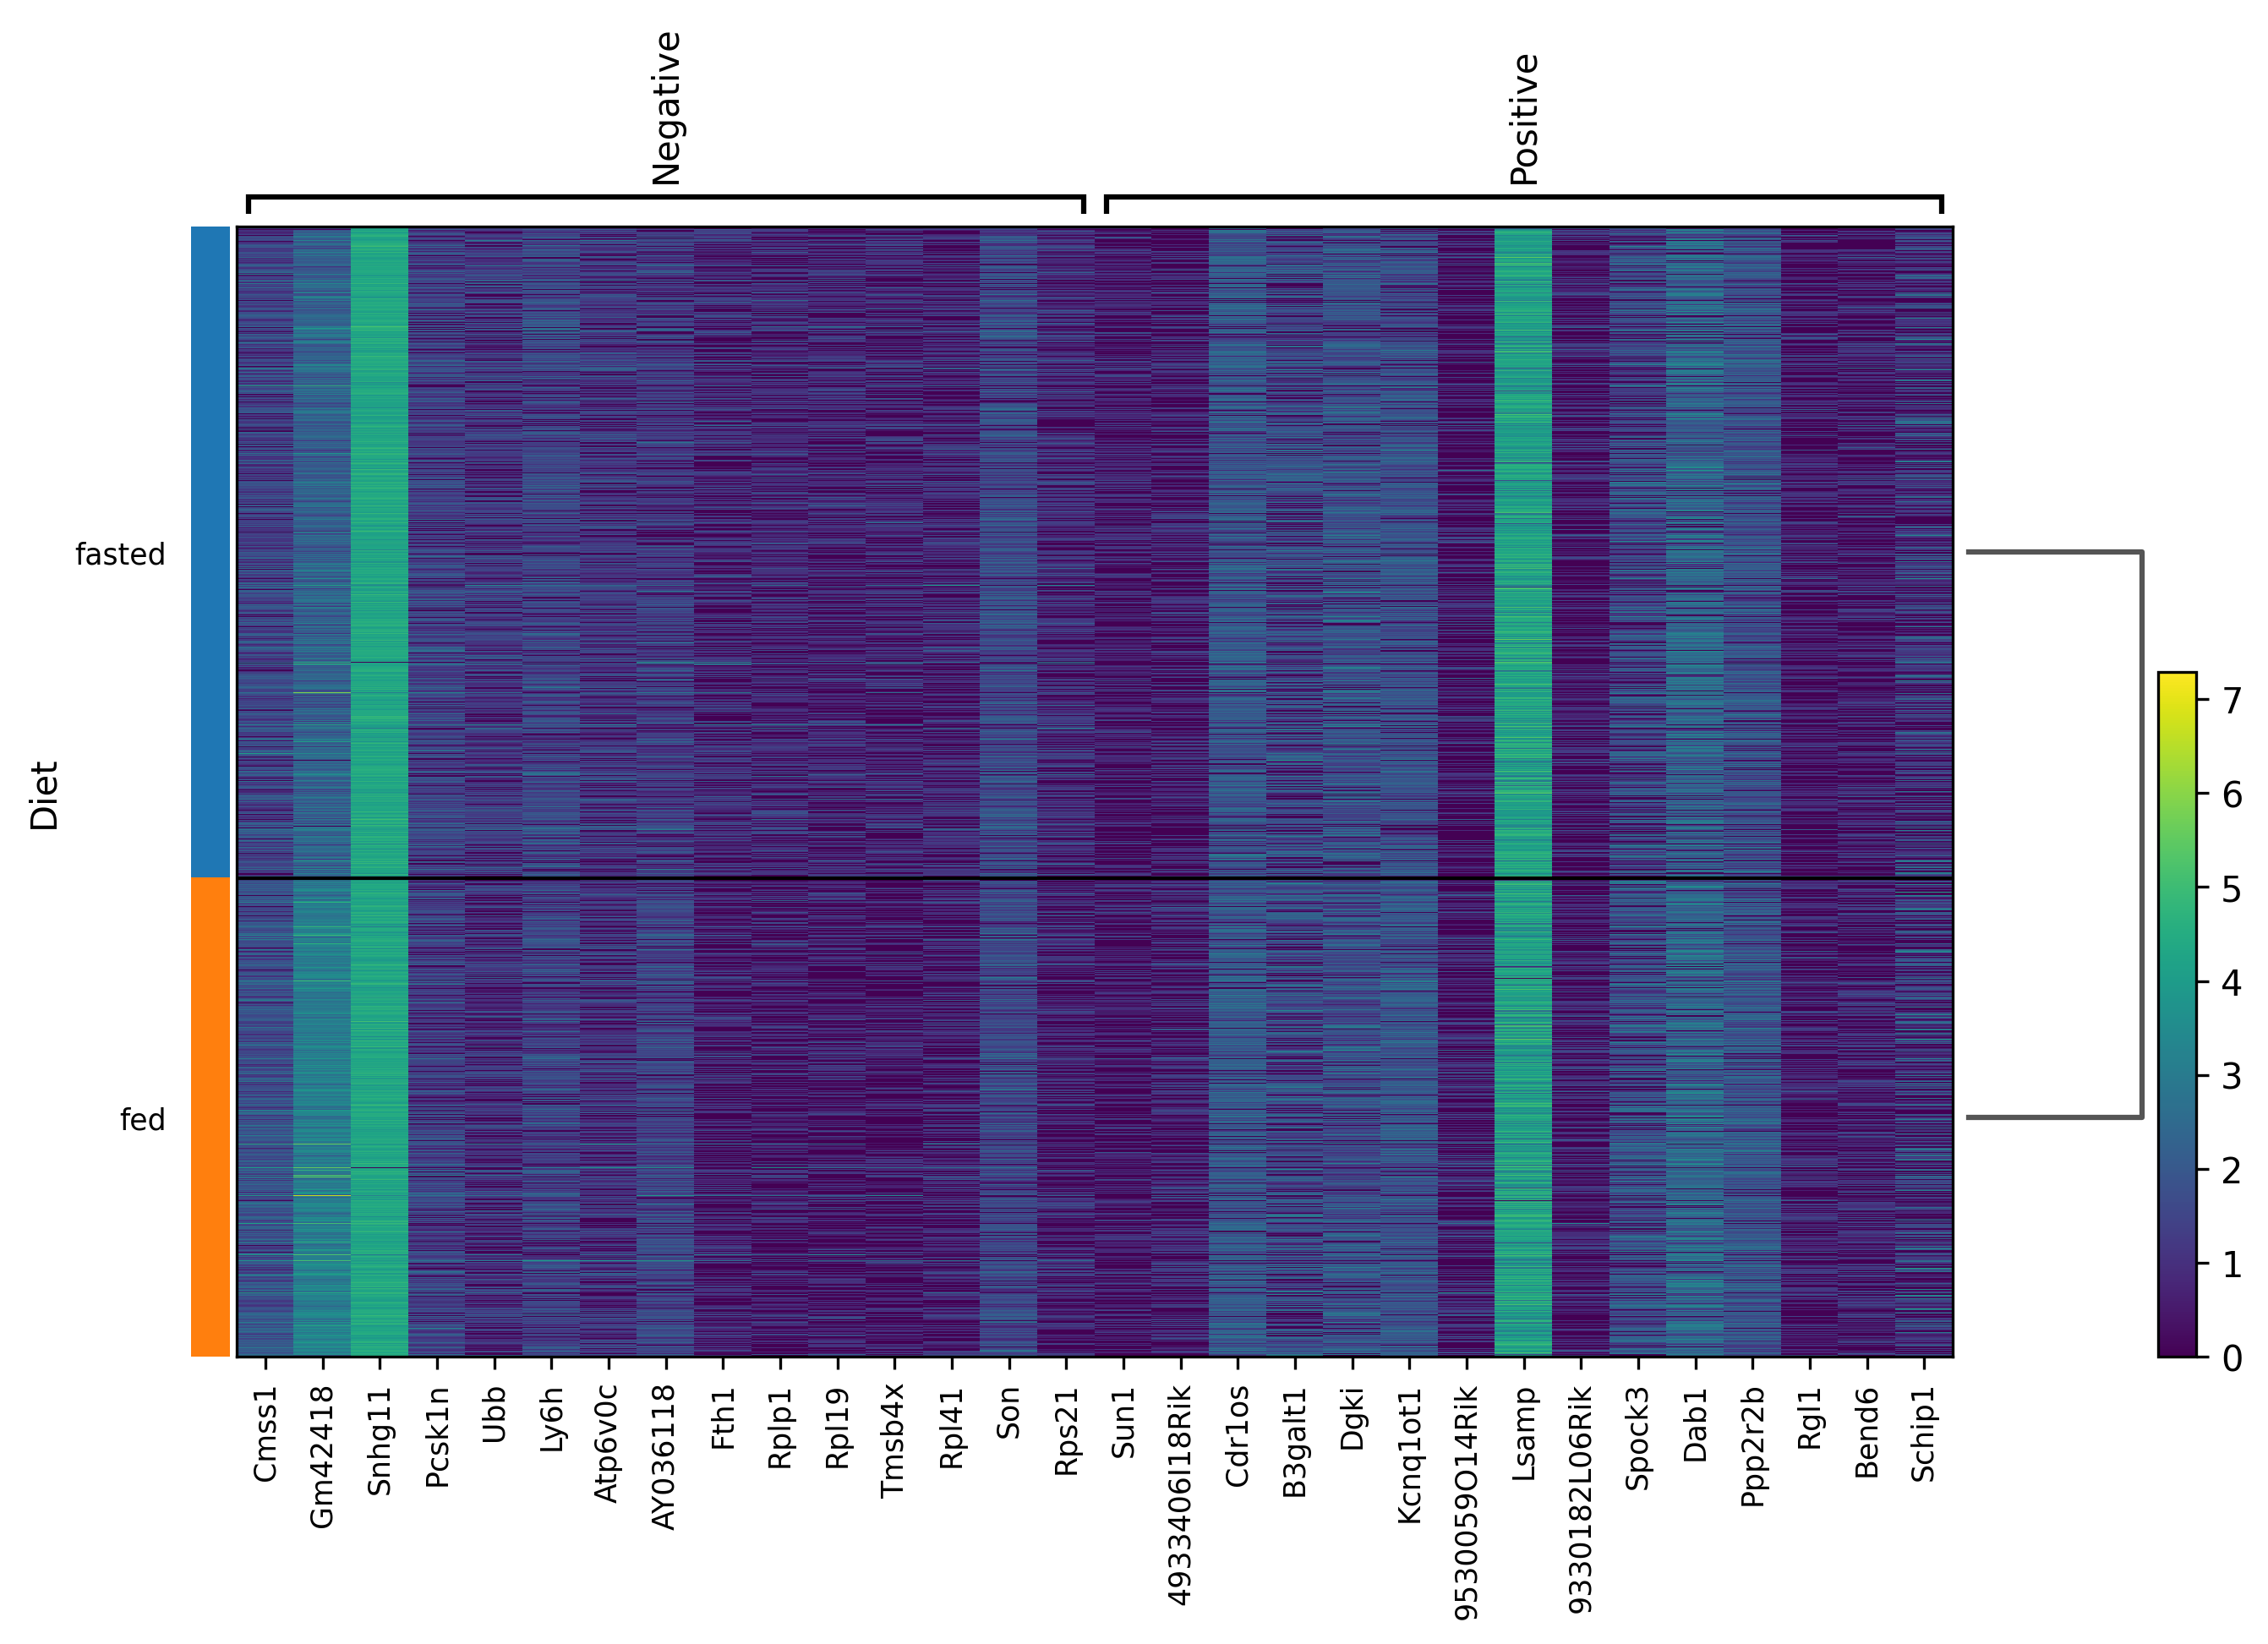

f_GLU
categories: fasted, fed
var_group_labels: Negative, Positive


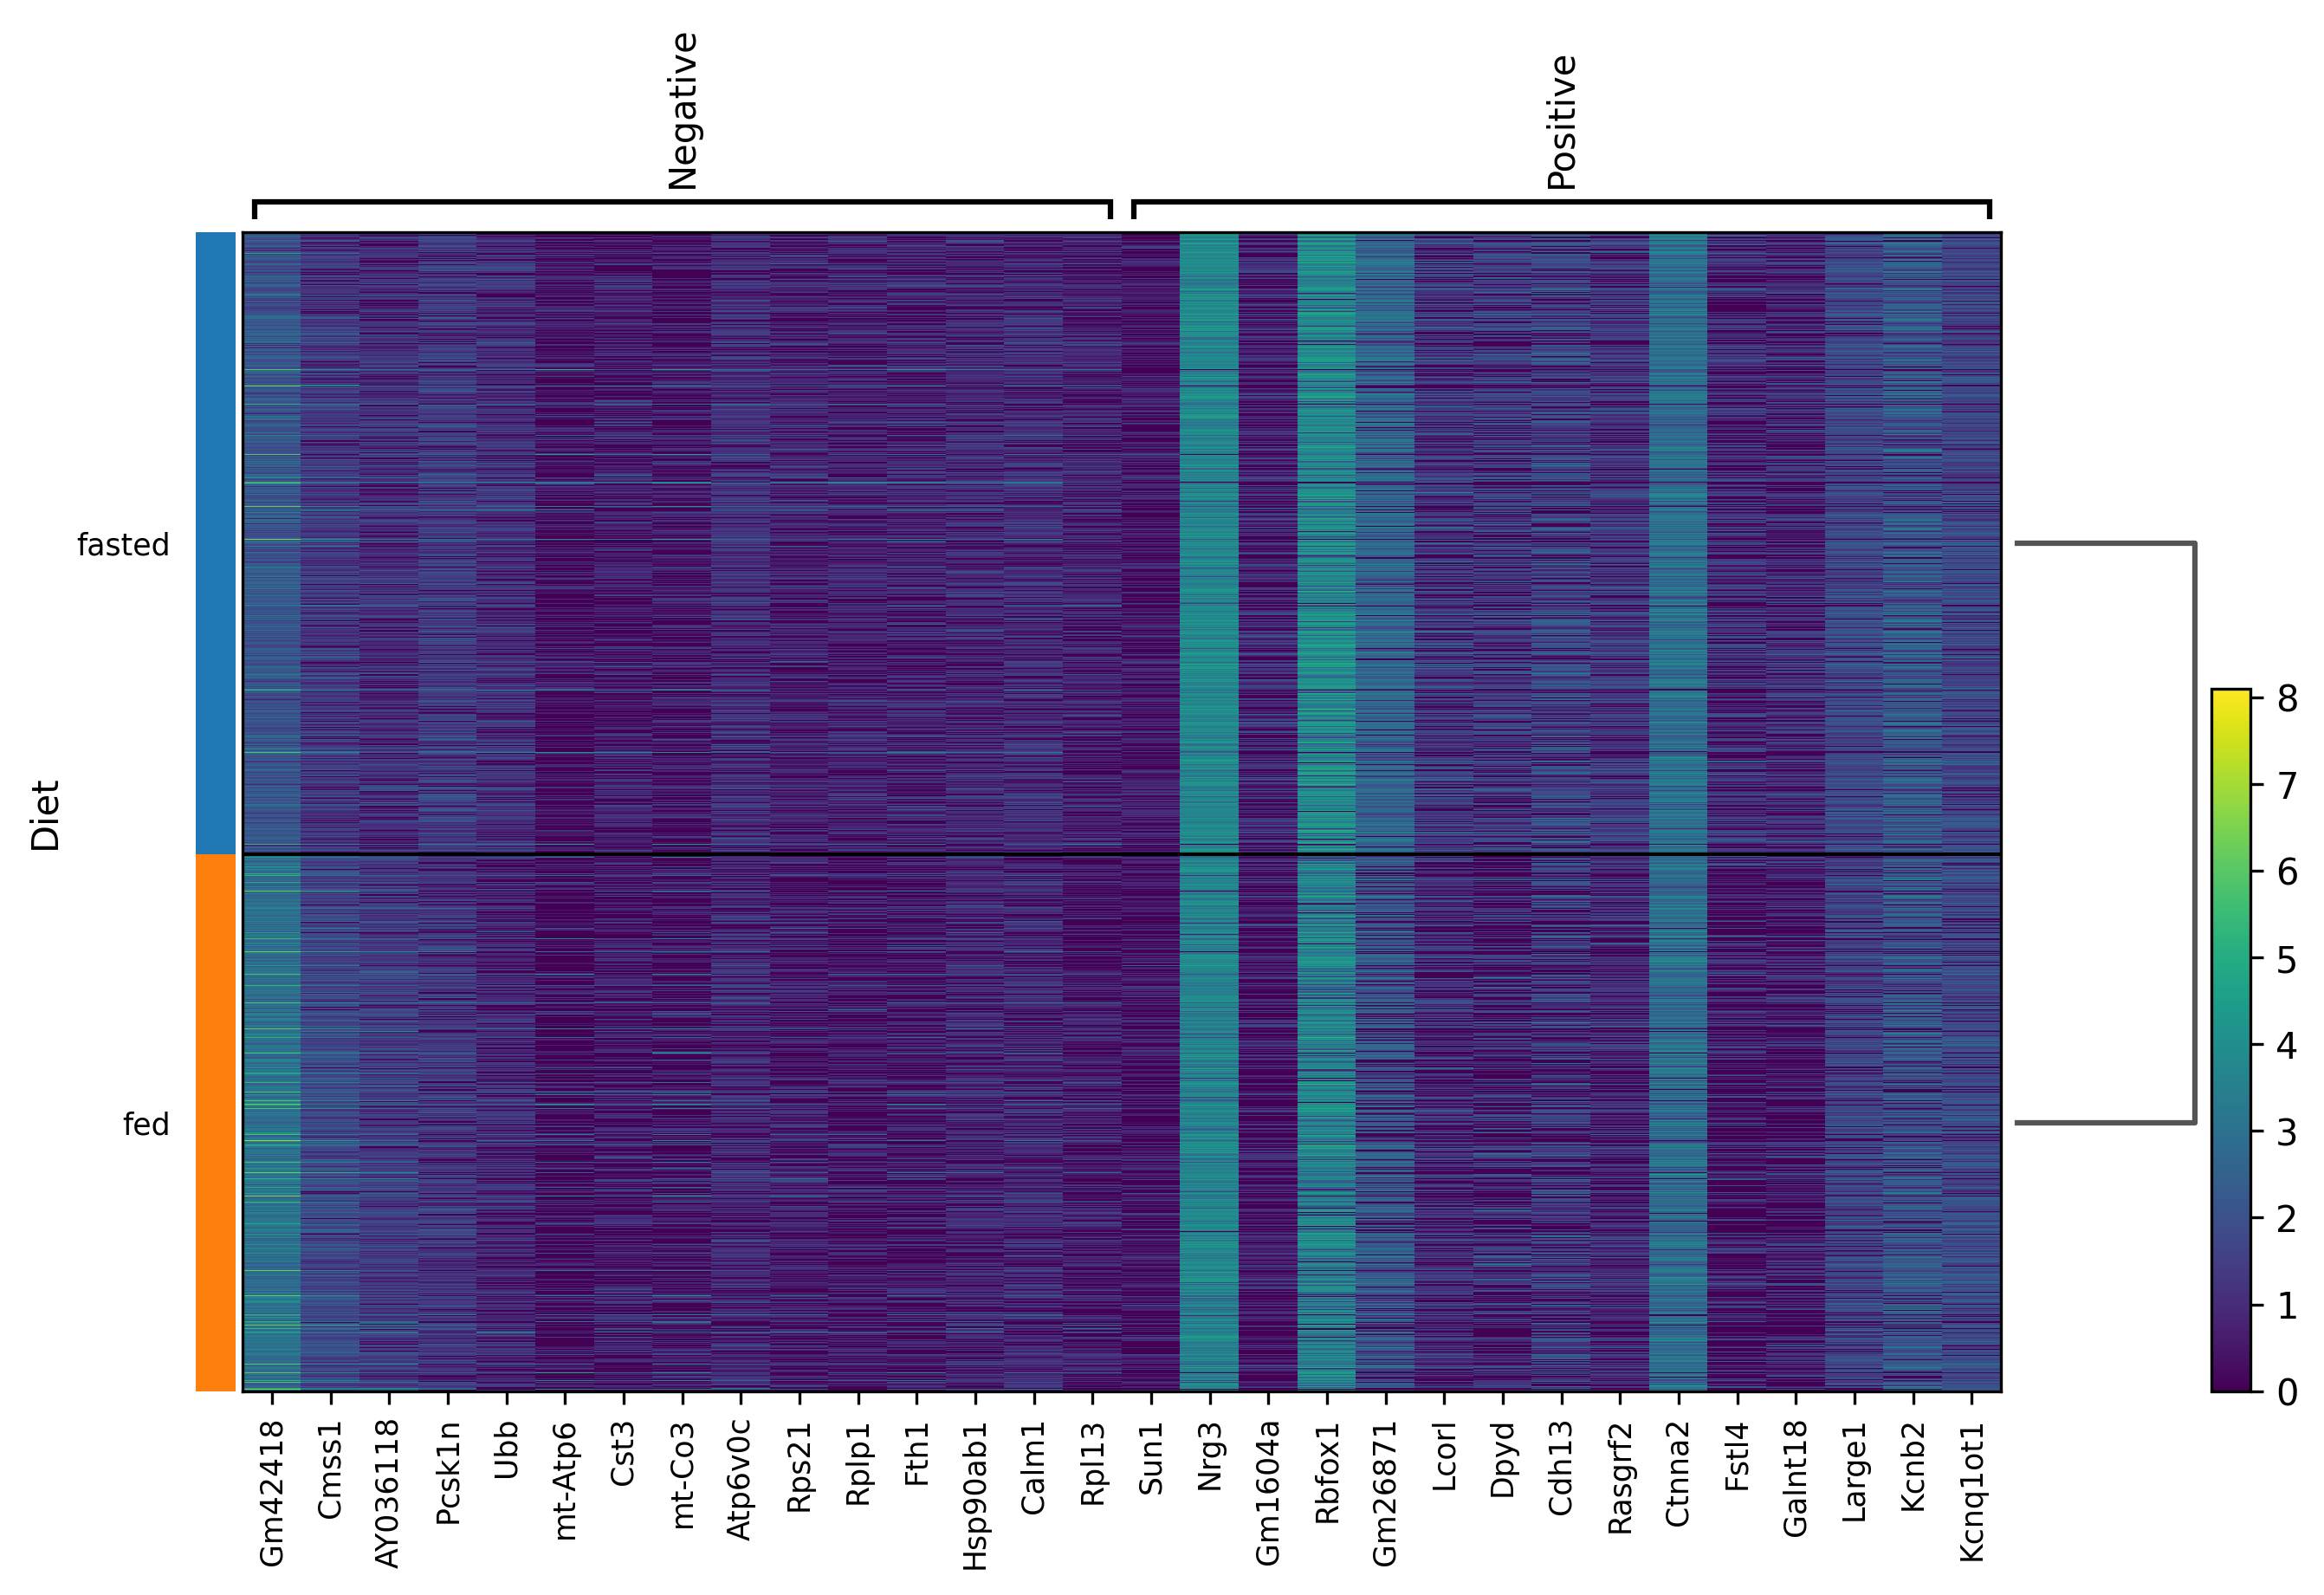

m_GABA
categories: fasted, fed
var_group_labels: Negative, Positive


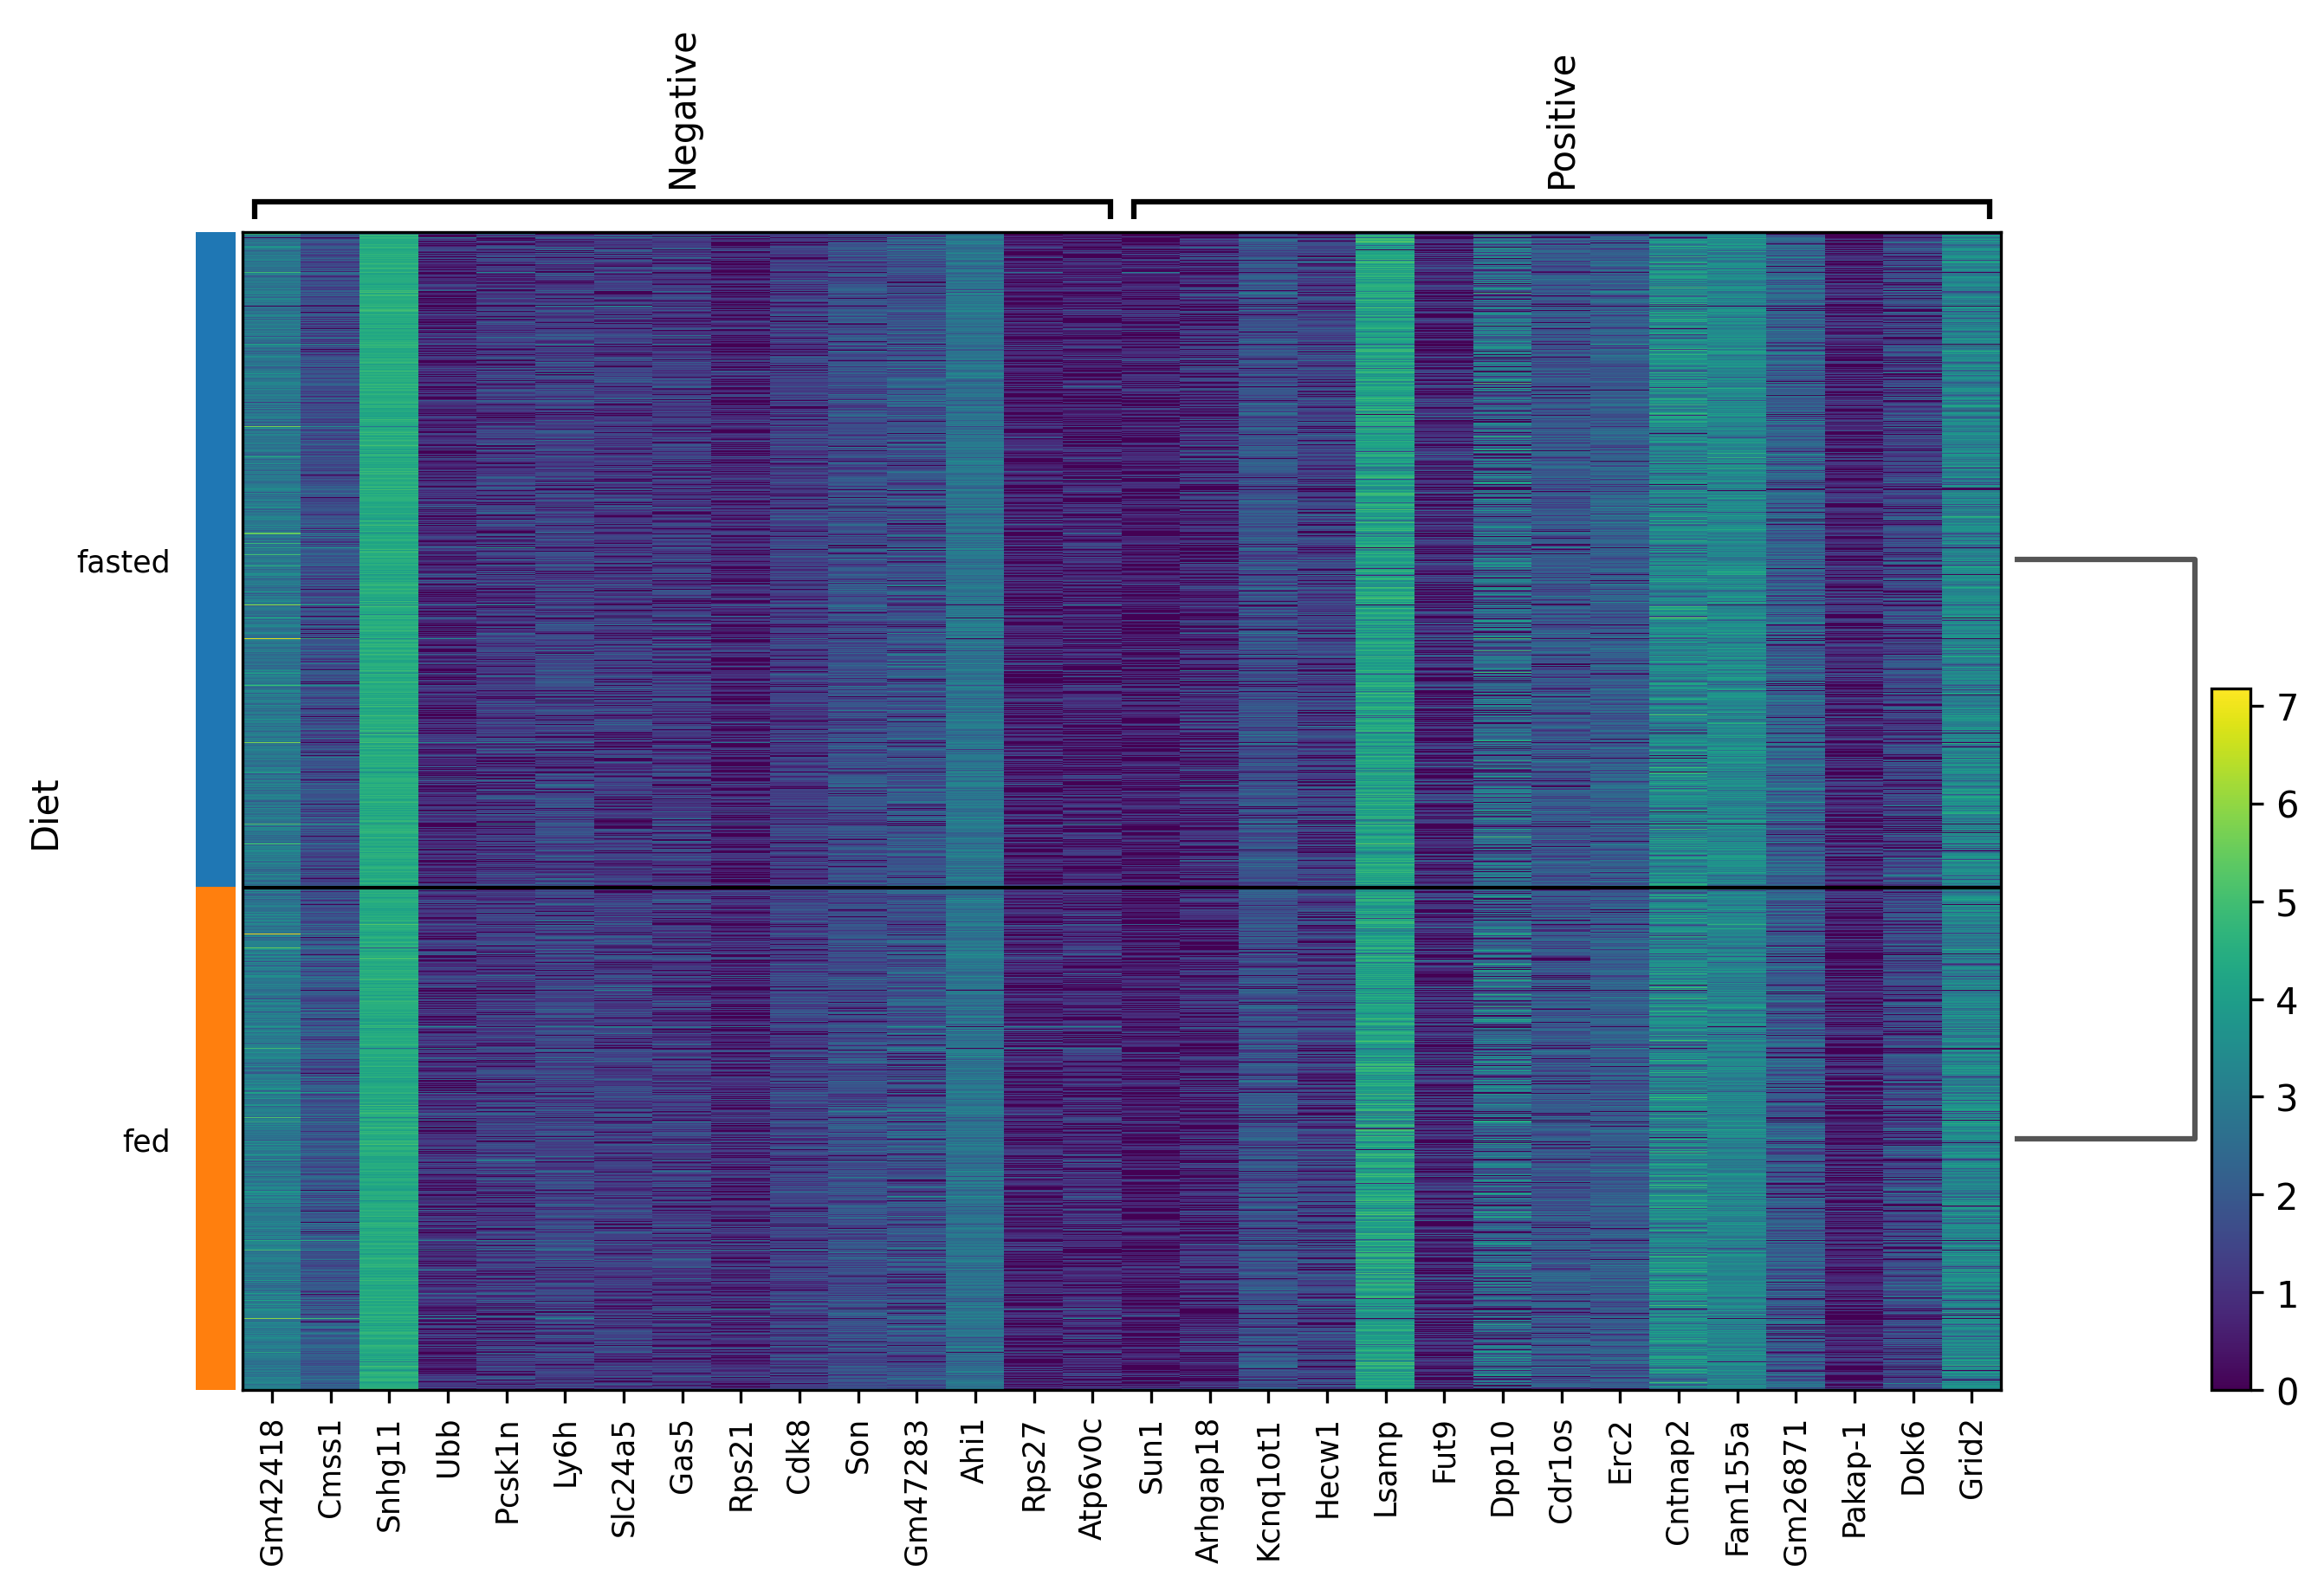

m_GLU
categories: fasted, fed
var_group_labels: Negative, Positive


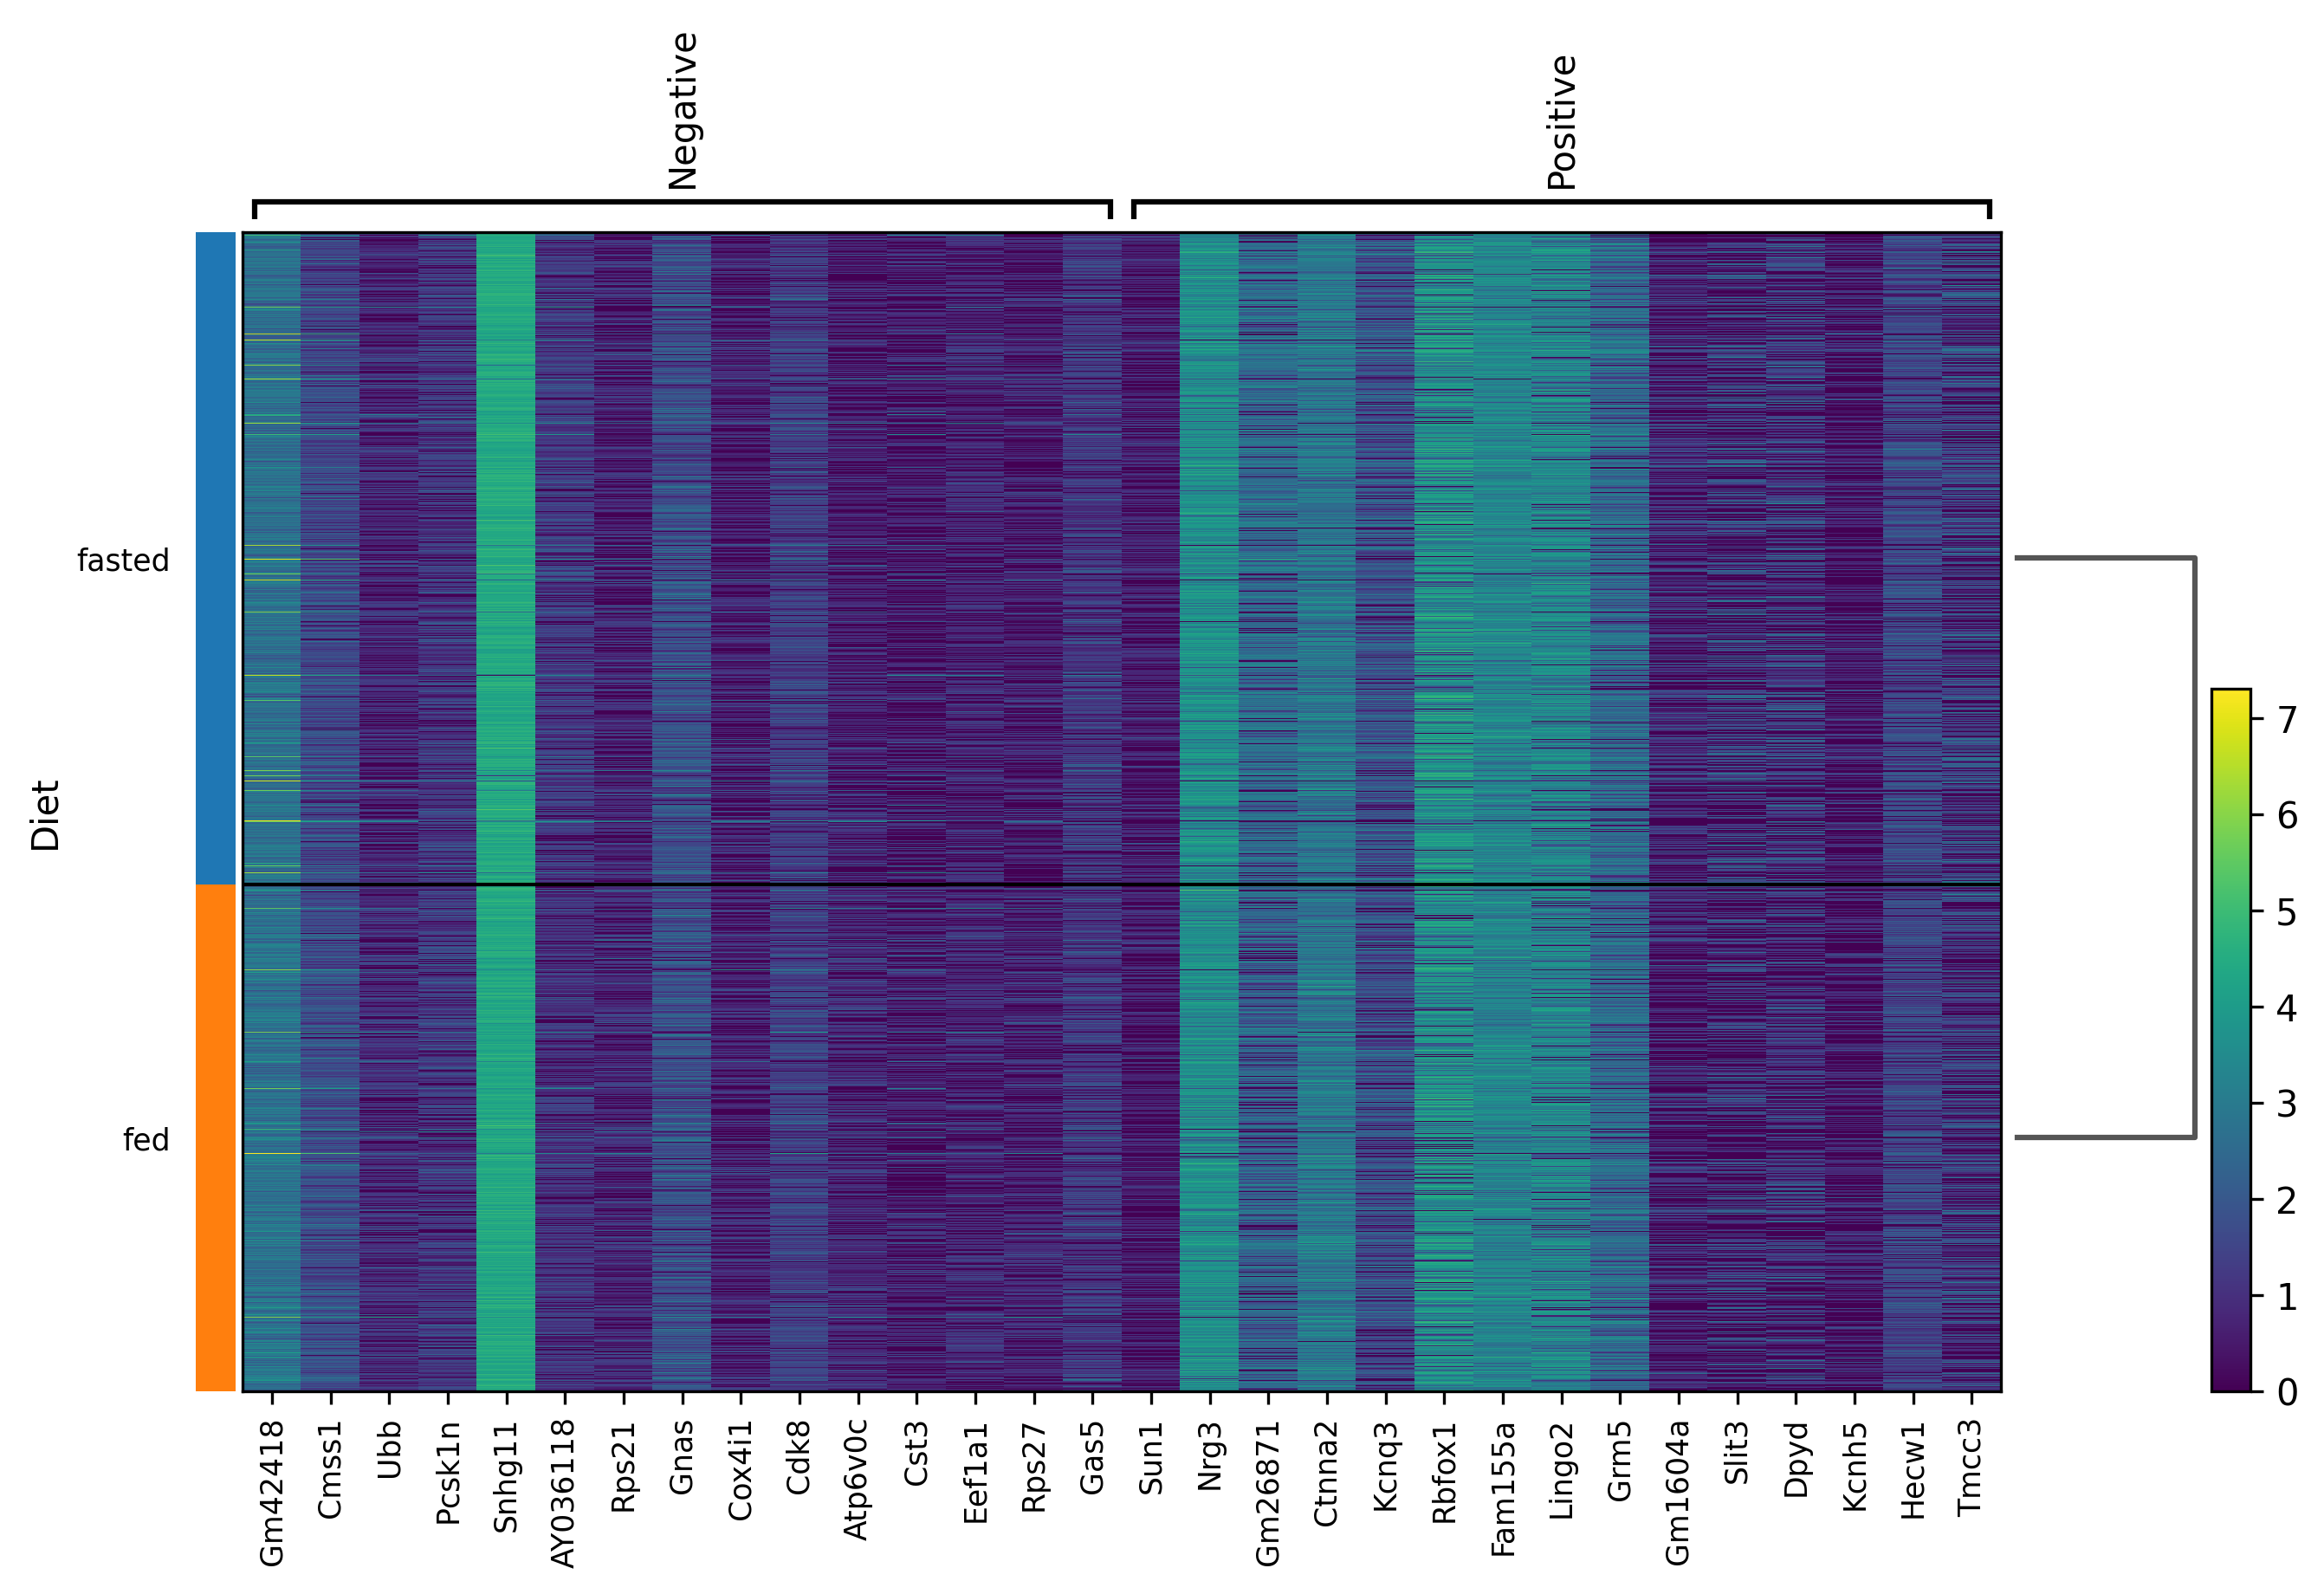

In [82]:
adata.obs['SUN1'] = np.where(adata.obs['sun1'] == 1, 'Positive', 'Negative')
adata.obs['SUN1'] = adata.obs['SUN1'].astype('category')

adata

for sex, sg in adata.obs.groupby('Sex'):
    for celltype, group in dg.groupby('broad_type'):

        if not celltype in [' GABA', ' GLU']:
            continue
        mask = (adata.obs['Sex'] == sex) & (adata.obs['broad_type'] == celltype)
        
        tmp = adata[mask]
        tmp.obs = tmp.obs.rename(columns={'Sun1' : 'Sun1_flag'})

        key = f"{sex}_{celltype.strip()}"
        print(key)

                    # get marker genes
        sc.tl.rank_genes_groups(tmp, 
                                groupby='SUN1',
                                method='wilcoxon',
                                key_added=key,
                                corr_method='benjamini-hochberg')

        sc.pl.rank_genes_groups_heatmap(tmp, 
                                        n_genes=15, 
                                        key=key, 
                                        groupby="Diet",
                                        show_gene_labels=True,)

In [73]:
?sc.pl.rank_genes_groups_heatmap

Signature:
sc.pl.rank_genes_groups_heatmap(
    adata: anndata._core.anndata.AnnData,
    groups: Union[str, Sequence[str]] = None,
    n_genes: Optional[int] = None,
    groupby: Optional[str] = None,
    gene_symbols: Optional[str] = None,
    var_names: Union[Sequence[str], Mapping[str, Sequence[str]], NoneType] = None,
    min_logfoldchange: Optional[float] = None,
    key: str = None,
    show: Optional[bool] = None,
    save: Optional[bool] = None,
    **kwds,
)
Docstring:
Plot ranking of genes using heatmap plot (see :func:`~scanpy.pl.heatmap`)

Parameters
----------
adata
    Annotated data matrix.
groups
    The groups for which to show the gene ranking.
n_genes
    Number of genes to show. This can be a negative number to show for
    example the down regulated genes. eg: num_genes=-10. Is ignored if
    `gene_names` is passed.
gene_symbols
    Column name in `.var` DataFrame that stores gene symbols. By default `var_names`
    refer to the index column of the `.var` DataFram

In [18]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
""" Distribution of marker gene expression """
query = [
    'Slc1a2',
    'Slc7a10',
    'Slc39a12',
    'Itih3',
    'Gad1',
    'Gad2',
    'Gabbr2',
    'Grin2b',
    'Slc17a6',
    'Aim2',
    'P2rx7',
    'Il10ra',
    'Ninj2',
    'Sec14l5', 
    'Drd2', 
    'Mest',
]


"""Extract expression for marker genes """
mask = (adata.obs['sun1'] == 1)
pos_ind = adata.obs[mask].index.to_list()
neg_ind = adata.obs[~mask].index.to_list()

pos = adata[pos_ind, query].to_df()
neg = adata[neg_ind, query].to_df()

print(f"{pos.shape=} {neg.shape=}")

pos['type'] = 'positive'
neg['type'] = 'negative'

pdf = pd.concat([pos, neg])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 9, 7

fig, axs = plt.subplots(4, 4, sharex=True)
axs = axs.ravel()

alpha_tol = 0.01

for i, g in enumerate(query):

    p = pdf[pdf['type'] == 'positive'][g].to_numpy()
    n = pdf[pdf['type'] == 'negative'][g].to_numpy()

    # score, p_val = scipy.stats.ranksums(p, n,
    #                                     alternative='two-sided')

    # sig = ""
    # if p_val <= alpha_tol:
    #     sig="*"

    # print(f"Gene: {g} {p_val=:4f}")

    sns.histplot(data=pdf, 
                 x=g,
                 bins=20,
                 hue='type',
                 kde=True,
                 legend=False,
                 palette=['#c23c17', 'grey'],
                 # lw=1,
                 ax=axs[i])

    axs[i].set_title(f"{g}")
    
    # break
    
# plt.yscale('log')
plt.tight_layout()

In [ ]:
""" Distribution of marker gene expression """
query = [
    'Slc1a2',
    'Slc7a10',
    'Slc39a12',
    'Itih3',
    'Gad1',
    'Gad2',
    'Gabbr2',
    'Grin2b',
    'Slc17a6',
    'Aim2',
    'P2rx7',
    'Il10ra',
    'Ninj2',
    'Sec14l5', 
    'Drd2', 
    'Mest',
]


"""Extract expression for marker genes """
mask = (adata.obs['sun1'] == 1)
pos_ind = adata.obs[mask].index.to_list()
neg_ind = adata.obs[~mask].index.to_list()

pos = adata[pos_ind, query].to_df()
neg = adata[neg_ind, query].to_df()

print(f"{pos.shape=} {neg.shape=}")

pdf = pd.concat([pos, neg])

pdf = pd.merge(pdf, adata.obs,
               how='left',
               left_index=True,
               right_index=True)

print(f"{pdf.shape}")
                
pdf.head()

In [ ]:
res = []

for ctype, group in pdf.groupby('C7_named_clean'):
    mask = (group['sun1'] == 1)
    p = group[mask].reset_index(drop=False)
    n = group[~mask].reset_index(drop=False)

    # print(f"{ctype} {p.shape=} {n.shape=}")

    ex = pd.concat([p[query].mean(), n[query].mean()], axis=1)
    ex.columns = ['positive', 'negative']

    
    ex['ctype'] = ctype
    ex = ex.reset_index(drop=False)

    ex['logfoldchange'] = ex[['positive', 'negative']].apply(lambda x: np.log1p(x[0]) - np.log1p(x[1]), axis=1)

    res.append(ex)
    # break

res = pd.concat(res)
res = pd.melt(res, id_vars=['ctype', 'index'], value_vars='logfoldchange')
res.head()

In [ ]:
pdf = pd.pivot_table(res, index='index', columns='ctype',
                 values='value')

pdf = np.abs(pdf)
print(pdf.max())

sns.heatmap(pdf.T,
            cmap='coolwarm',
            lw=1,
            cbar=False,
            square=True)

plt.ylabel("")
plt.xlabel("")

In [ ]:
# ut.makeColorbar('coolwarm', 0.2, 3, "Abs. Fold Change (log)", 'vertical', ['0', '0.5'])

In [ ]:
""" Distribution of marker gene expression """
query = [
    'Mc3r', 
    "Agrp", 
    "Npy", 
    "Nr5a1", 
    "Pomc", 
    "Mc4r", 
    "Gnrhr", 
    "Gnrh1", 
    "Ghrh", 
    "Ghrhr", 
    "Sst", 
    "Esr1",
    "Lepr",
    "Pnoc",
    "Adcyap1",
    "Foxp2", 
    "Dlk1",
    "Kiss1", 
    "Tac2", 
    "Pdyn", 
    "Rprm",
    "Oxtr",
    "Drd2",
    "Gria3", 
    "Grik1", 
    "Grik3", 
    "Gabra5", 
    "Gabra2", 
    "Syndig1",
    "Pak3",
    "Ptk2b", 
    "Plk2",
    "Trh",
    "Glp1r",
]


"""Extract expression for marker genes """
mask = (adata.obs['sun1'] == 1)
pos_ind = adata.obs[mask].index.to_list()
neg_ind = adata.obs[~mask].index.to_list()

pos = adata[pos_ind, query].to_df()
neg = adata[neg_ind, query].to_df()

print(f"{pos.shape=} {neg.shape=}")

pdf = pd.concat([pos, neg])

pdf = pd.merge(pdf, adata.obs,
               how='left',
               left_index=True,
               right_index=True)

print(f"{pdf.shape}")
                
res = []

for ctype, group in pdf.groupby('C25_named_clean'):
    mask = (group['sun1'] == 1)
    p = group[mask].reset_index(drop=False)
    n = group[~mask].reset_index(drop=False)

    # print(f"{ctype} {p.shape=} {n.shape=}")

    ex = pd.concat([p[query].mean(), n[query].mean()], axis=1)
    ex.columns = ['positive', 'negative']

    
    ex['ctype'] = ctype
    ex = ex.reset_index(drop=False)

    ex['logfoldchange'] = ex[['positive', 'negative']].apply(lambda x: np.log1p(x[0]) - np.log1p(x[1]), axis=1)

    res.append(ex)
    # break

res = pd.concat(res)
res = pd.melt(res, id_vars=['ctype', 'index'], value_vars='logfoldchange')
res.head()

In [ ]:
pdf = pd.pivot_table(res, index='index', columns='ctype',
                 values='value')

pdf = np.abs(pdf)
print(pdf.max())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 10

sns.heatmap(pdf,
            cmap='coolwarm',
            lw=0.5,
            cbar=False,
            square=True)

plt.ylabel("")
plt.xlabel("")

In [ ]:
break

In [ ]:
"""Randomly sampled genes """

sample_n = 5000
query = np.random.choice(adata.var_names, sample_n, replace=False)

"""Extract expression for marker genes """
mask = (adata.obs['sun1'] == 1)
pos_ind = adata.obs[mask].index.to_list()
neg_ind = adata.obs[~mask].index.to_list()

pos = adata[pos_ind, query].to_df()
neg = adata[neg_ind, query].to_df()

print(f"{pos.shape=} {neg.shape=}")

pdf = pd.concat([pos, neg])

pdf = pd.merge(pdf, adata.obs,
               how='left',
               left_index=True,
               right_index=True)

print(f"{pdf.shape}")
                
res = []

allcount = 0
for ctype, group in pdf.groupby('C7_named_clean'):
    print(f"working... {ctype}")
    mask = (group['sun1'] == 1)
    p = group[mask].reset_index(drop=False)
    n = group[~mask].reset_index(drop=False)
    allcount += p.shape[0]

    for g in query:

        score, pval = scipy.stats.ranksums(p[g], n[g])
        # score, pval = scipy.stats.ttest_ind(p[g], n[g])

        pos_mean = p[g].mean()
        neg_mean = n[g].mean()
        lfc = np.log2(pos_mean + 1) - np.log2(neg_mean + 1)
        
        row = {
            'celltype' : ctype,
            'gene' : g,
            'score' : score, 
            'pval' : pval,
            'log2foldchange' : lfc,
            'sun1_pos_mean' : pos_mean,
            'sun1_neg_mean' : neg_mean,
            'sun1_pos_std' : p[g].std(),
            'sun1_neg_std' : n[g].std(),
            'sun1_pos_n' : len(p[g]),
            'sun1_neg_n' : len(n[g]),
            # 'sun1_pos_reads' : adata[p.index.to_list(), [g]].layers['counts'].sum(),
            # 'sun1_neg_reads' : adata[n.index.to_list(), [g]].layers['counts'].sum(),
        }
        res.append(row)

        
res = pd.DataFrame(res)
res.head()
# allcount

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2

pdf = res.copy()
pdf = pdf.sort_values(by='celltype')

sns.histplot(data=res, 
             x='pval',
             bins=100,
             kde=True,)
             # hue='celltype',
             # log_scale=True)

sns.despine()
# sns.move_legend(plt.gca(), 
#                 title="",
#                 frameon=False,
#                 loc='upper right',
#                 bbox_to_anchor=(1.6, 1))

plt.xlim([0.0, 1.1])
plt.xlabel(r"$p$-value")


In [ ]:
pdf = res.copy()
pdf = pdf.sort_values(by='celltype')
neuro = [' GABA', ' GLU']
pdf = pdf[pdf['celltype'].isin(neuro)]

pdf['log10p'] = -1 * np.log10(pdf['pval'])


sns.scatterplot(data=pdf, 
                x='log2foldchange',
                y='log10p',
                ec='none',
                color='grey',
                s=2,
                alpha=0.5)

pdf.head()
sns.despine()

In [ ]:
pdf = res.copy()
pdf = pdf.sort_values(by='celltype')

n_query = 500
ascending = False # false means highest upregulated  in sun1+

alpha = 0.05
ntests = len(pdf)
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alphaHat}")

pdf = pdf[pdf['pval'] <= alphaHat]
print(pdf['celltype'].value_counts())
print()

neuro = [' GABA', ' GLU']
pdf = pdf[pdf['celltype'].isin(neuro)]

pdf = pdf.sort_values(by='log2foldchange', ascending=ascending)
print(pdf.head())

query_genes = list(pdf['gene'].head(n_query).unique())

# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

e_alpha = 0.05

edf = gget.enrichr(query_genes, database=db)
edf = edf[edf['adj_p_val'] <= e_alpha]
pd.set_option('display.max_colwidth', 150)

# outpath = "GABA_GLU_Sun1_positive_downregulated_genes.csv"
# edf.to_csv(outpath, index=False)

edf[['path_name', 'adj_p_val', 'overlapping_genes']]

In [ ]:
outpath = "GABA_GLU_Sun1_positive_DEG.csv"
pdf.to_csv(outpath, index=False)
pdf = pdf.sort_values(by='log2foldchange', ascending=ascending)
pdf.head(50)

In [ ]:
# pdf = res.copy()
# pdf = pdf.sort_values(by='celltype')

# alpha = 0.05
# ntests = len(pdf)
# alphaHat = 1 - ((1-alpha) ** (1/ntests))
# print(f"{alphaHat}")

# pdf = pdf[pdf['pval'] <= alphaHat]
# print(pdf['celltype'].value_counts())
# print()

# new_query = pdf[pdf['celltype'] == ' GABA']
# new_query


In [ ]:
# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

e_alpha = 0.05

edf = gget.enrichr(list(new_query['gene'].unique()), database=db)
edf = edf[edf['adj_p_val'] <= e_alpha]
pd.set_option('display.max_colwidth', 150)
edf[['path_name', 'adj_p_val', 'overlapping_genes']]

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2

pdf = res.copy()
pdf = pdf.sort_values(by='celltype')

sns.kdeplot(data=res, 
             x='pval',
             # bins=500,
             # kde=True,
             palette='nipy_spectral',
             hue='celltype',)
             # log_scale=True)

sns.despine()
sns.move_legend(plt.gca(), 
                title="",
                frameon=False,
                loc='upper right',
                bbox_to_anchor=(1.6, 1))

plt.xlim([0.0, 0.05])



In [ ]:
pdf = res.copy()
pdf = pdf.sort_values(by='celltype')

alpha_threshold = 

pdf.head()

In [ ]:
# p = pd.pivot_table(pdf, index=['C7_named_clean', 'Diet', 'Sex', 'Sun1'], 
#                     columns=query, 
#                     values=query,
#                     aggfunc='mean').reset_index(drop=False)

# print(f"{p.shape=}")
# print(p.head())

In [ ]:
break

In [ ]:
break

In [ ]:
gene = 'Sun1'
mask = (adata[:, [gene]].layers['counts'].todense() > 0)
gene_pos = adata.obs[mask]
print(f"{gene_pos.shape=}")
counts = gene_pos['broad_type'].value_counts().reset_index()

counts = counts.sort_values(by='index')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

total_counts = adata.obs['broad_type'].value_counts().reset_index()
total_counts = total_counts.sort_values(by='index')

sns.barplot(data=total_counts, 
            y='index',
            x='broad_type',
            palette='nipy_spectral',
            ec='k',
            )

ax = plt.gca()

plt.ylabel("")
divider = make_axes_locatable(ax)
ax2 = divider.append_axes("right", size="100%", pad="10%")

sns.barplot(data=counts, 
            y='index',
            x='broad_type',
            palette='nipy_spectral',
            ec='k')

ax2.set_ylabel("")
ax2.set_yticks([])
ax2.set_yticklabels([])

ax2.set_xlabel("n Cells")
ax.set_xlabel("n Cells")

ax.set_title("All Cells")
ax2.set_title("Mc3r+ Cells")

ax2.set_xscale('log')
ax.set_xscale('log')

print(counts)


sns.despine()

In [ ]:

sample_size = 100
ctype = ' GLU'
gene = 'Sun1'
condition = 'fed_m'

obs = adata.obs.copy()

# add a binary flag for a target gene
obs['flag'] = np.ravel((adata[:, [gene]].layers['counts'] > 0).todense())

type_mask = (obs['broad_type'] == ctype) & (obs['batch'] == condition)
obs = obs[type_mask]

print(f"{obs.shape=}")
print(obs['flag'].value_counts())

# binary flag the cells
mask = (obs['flag'] == True)

pos = obs[mask].sample(sample_size).index
neg = obs[~mask].sample(sample_size).index


print(f"{pos.shape=}")
print(f"{neg.shape=}")

X1 = pd.DataFrame(adata[pos.to_list(), :].obsm['X_pca'].T).corr()
X2 = pd.DataFrame(adata[neg.to_list(), :].obsm['X_pca'].T).corr()

print(f"{X1.shape=}")
print(f"{X2.shape=}")

fig, axs = plt.subplots(1, 2)

axs[0].imshow(X1)
axs[0].set_title("Sun1+")

axs[1].imshow(X2)
axs[1].set_title("Sun1-")

In [ ]:
X1_corrs = np.triu(X1, k=1).ravel()
X2_corrs = np.triu(X2, k=1).ravel()


kres = scipy.stats.ks_2samp(X1_corrs, X2_corrs)
print(kres)

pdf = pd.DataFrame({'Sun1+' : X1_corrs,
                    'Sun1-' : X2_corrs,})

pdf = pd.melt(pdf)


sns.histplot(data=pdf, 
             x='value',
             hue='variable',
             bins=100)

plt.yscale('log')
plt.xlabel("Correlation")
plt.ylabel("Count")

sns.move_legend(plt.gca(), 
                loc='upper right',
                title="",
                frameon=False, 
                bbox_to_anchor=(1, 1))

sns.despine()


In [ ]:
break

In [ ]:
sc.tl.rank_genes_groups(adata, 
                        groupby='batch', 
                        method='wilcoxon',
                        key_added='pairwise_batch',
                        corr_method='benjamini-hochberg') 

sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        key='pairwise_batch',
                        sharey=False,
                        ncols=2)

In [ ]:
deg = sc.get.rank_genes_groups_df(adata, 
                                  group=None,
                                  key='pairwise_batch')

deg['log10p'] = -1 * np.log10(deg['pvals'])
alpha = 0.05
thresh = 1
label_n = 5


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 4
fig, axs =  plt.subplots(2, 2, sharex=True)
axs = axs.ravel()

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=4,)


title_map = {
    'fasted_f' : "Male-Fed", 
    'fasted_m' : "Male-Fasted",
    'fed_f' :  "Female-Fed",
    'fed_m' : "Female-Fasted",
}

res = []

for i, group in enumerate(deg['group'].unique()):
    # subset group of interest
    pdf = deg[deg['group'] == group].reset_index(drop=True)

    mask = (pdf['logfoldchanges'] > -2) & (pdf['logfoldchanges'] < 2) & (pdf['pvals'] <= alpha)
    pdf = pdf[mask].reset_index(drop=True)

    sns.scatterplot(data=pdf, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.6,
                color='grey',
                zorder=1,
                ax=axs[i],
                s=5)

    mask = (pdf['logfoldchanges'] < -thresh) | (pdf['logfoldchanges'] > thresh)
    hi_deg = pdf[mask].reset_index(drop=True)
    print(f"{group=} {hi_deg.shape=}")

    res.append(hi_deg)

    sns.scatterplot(data=hi_deg, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.6,
                color='r',
                zorder=2,
                ax=axs[i],
                s=5)

    axs[i].axvline(x=thresh, lw=1, c='k', ls=':', zorder=3)
    axs[i].axvline(x=-thresh, lw=1, c='k', ls=':', zorder=3)
    axs[i].set_yticks([], [])

    label_point(hi_deg['logfoldchanges'].head(label_n), 
                hi_deg['log10p'].head(label_n), 
                hi_deg['names'].head(label_n), 
                axs[i]) 


    label_point(hi_deg['logfoldchanges'].tail(label_n), 
            hi_deg['log10p'].tail(label_n), 
            hi_deg['names'].tail(label_n), 
            axs[i]) 

    if i == 0 or i == 2:
        axs[i].set_ylabel(r"-log$_{10}$($p$-value)")
    else:
        axs[i].set_ylabel("")

    if i == 2 or i == 3:
        axs[i].set_xlabel(r"Fold Change (log$_{2}$)")
    else:
        axs[i].set_xlabel("")

    axs[i].set_title(title_map[group])

res = pd.concat(res)
print(f"{res.shape=}")

plt.tight_layout()
sns.despine()

In [ ]:
outpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/results/all_batch_DEG.csv"
res.to_csv(outpath, index=False)
res.head()

In [ ]:
print(adata.obs["broad_type"] .value_counts())

""" Subset the nuerons """
# ctypes = [' GLU', ' GABA']
ctypes = [' GABA']
ndata = adata[adata.obs["broad_type"].isin(ctypes)].copy()

sc.tl.rank_genes_groups(ndata, 
                        groupby='batch', 
                        method='wilcoxon',
                        key_added='pairwise_batch',
                        corr_method='benjamini-hochberg') 

sc.pl.rank_genes_groups(ndata, 
                        n_genes=20, 
                        key='pairwise_batch',
                        sharey=False,
                        ncols=2)



In [ ]:
deg = sc.get.rank_genes_groups_df(ndata, 
                                  group=None,
                                  key='pairwise_batch')

print(f"{deg.shape=}")
deg['log10p'] = -1 * np.log10(deg['pvals'])
alpha = 0.05
thresh = 1
label_n = 5


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 4
fig, axs =  plt.subplots(2, 2, sharex=True)
axs = axs.ravel()

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=4,)


title_map = {
    'fasted_f' : "Male-Fed", 
    'fasted_m' : "Male-Fasted",
    'fed_f' :  "Female-Fed",
    'fed_m' : "Female-Fasted",
}

res = []

for i, group in enumerate(deg['group'].unique()):
    # subset group of interest
    pdf = deg[deg['group'] == group].reset_index(drop=True)

    mask = (pdf['logfoldchanges'] > -2) & (pdf['logfoldchanges'] < 2) & (pdf['pvals'] <= alpha)
    pdf = pdf[mask].reset_index(drop=True)

    sns.scatterplot(data=pdf, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.6,
                color='grey',
                zorder=1,
                ax=axs[i],
                s=5)

    mask = (pdf['logfoldchanges'] < -thresh) | (pdf['logfoldchanges'] > thresh)
    hi_deg = pdf[mask].reset_index(drop=True)
    print(f"{group=} {hi_deg.shape=}")

    res.append(hi_deg)

    sns.scatterplot(data=hi_deg, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.6,
                color='r',
                zorder=2,
                ax=axs[i],
                s=5)

    axs[i].axvline(x=thresh, lw=1, c='k', ls=':', zorder=3)
    axs[i].axvline(x=-thresh, lw=1, c='k', ls=':', zorder=3)
    axs[i].set_yticks([], [])

    label_point(hi_deg['logfoldchanges'].head(label_n), 
                hi_deg['log10p'].head(label_n), 
                hi_deg['names'].head(label_n), 
                axs[i]) 


    label_point(hi_deg['logfoldchanges'].tail(label_n), 
            hi_deg['log10p'].tail(label_n), 
            hi_deg['names'].tail(label_n), 
            axs[i]) 

    if i == 0 or i == 2:
        axs[i].set_ylabel(r"-log$_{10}$($p$-value)")
    else:
        axs[i].set_ylabel("")

    if i == 2 or i == 3:
        axs[i].set_xlabel(r"Fold Change (log$_{2}$)")
    else:
        axs[i].set_xlabel("")

    axs[i].set_title(title_map[group])

res = pd.concat(res)
print(f"{res.shape=}")

plt.tight_layout()
sns.despine()

In [ ]:
break

In [ ]:
sc.tl.rank_genes_groups(adata, 
                        groupby='Sex', 
                        method='wilcoxon',
                        key_added='sex',
                        corr_method='bonferroni') # default correctiong is bengamin

sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        key='sex',
                        sharey=False)

In [ ]:
deg = sc.get.rank_genes_groups_df(adata, 
                                  group=None,
                                  key='pairwise_batch')


deg = deg[deg['group'] == 'f'].reset_index(drop=True)
deg['log10p'] = -1 * np.log10(deg['pvals'])
alpha = 0.05
thresh = 1

mask =  (deg['logfoldchanges'] > -2) & (deg['logfoldchanges'] < 2) & (deg['pvals'] <= alpha)
deg = deg[mask].reset_index(drop=True)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2

sns.scatterplot(data=deg, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.6,
                color='grey',
                zorder=1,
                s=5)

mask = (deg['logfoldchanges'] < -thresh) | (deg['logfoldchanges'] > thresh)

hi_deg = deg[mask].reset_index(drop=True)
print(f"{hi_deg.shape=}")

sns.scatterplot(data=hi_deg, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.6,
                color='r',
                zorder=2,
                s=5)

plt.axvline(x=thresh, lw=1, c='k', ls=':', zorder=0)
plt.axvline(x=-thresh, lw=1, c='k', ls=':', zorder=0)
plt.yticks([], [])
plt.ylabel(r"-log$_{10}$($p$-value)")
plt.xlabel(r"Fold Change (log$_{2}$)")
sns.despine()

In [ ]:
hi_deg.sort_values(by='logfoldchanges')

In [ ]:
break

In [ ]:
sc.tl.rank_genes_groups(adata, 
                        groupby='Diet', 
                        method='wilcoxon',
                        key_added='diet',
                        corr_method='benjamini-hochberg') # default correctiong is bengamin

sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        key='diet',
                        sharey=False)

In [ ]:
sc.tl.rank_genes_groups(adata, 
                        groupby='broad_type', 
                        method='wilcoxon',
                        key_added='broad_type',
                        corr_method='benjamini-hochberg') # default correctiong is bengamin

sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        key='broad_type',
                        sharey=False,
                        ncols=3)

In [ ]:
sc.tl.rank_genes_groups(adata, 
                        groupby='reference_embedding_C25_named_clean', 
                        method='wilcoxon',
                        key_added='subtype',
                        corr_method='benjamini-hochberg') # default correctiong is bengamin

sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        key='subtype',
                        sharey=False,
                        ncols=3)

In [ ]:
deg = sc.get.rank_genes_groups_df(adata, 
                                  group=None,
                                  key='sex')

deg.head()

In [ ]:
# NOW for some exploration of Mc3r+ cells